<h1><center>Vietnam Stock Market - Momentum Stategy</center></h1>
<h3><i>Content:</i></h3>
<h3>1. Problem statement</h3>
  <li>What is momentum, mean reversion & seasionality</li>
  <li>Why & How you find it</li>
<h3>2. Data wrangling & EDA</h3>
  <li>Historgram</li>
  <li>Bolinger band, high-low band (breakout)</li>
  <li>View time series/cross sectional for pattern recognition</li>
  <li>Hypothesis refinement</li>
<h3>3. Model construction</h3>
  <p>Candidate selection</p>
  <p>Quantopian zipline & alphalens</p>
  <p>3.1. Risk model</p>
  <p>3.2. Alpha model</p>
  <p>3.3. Multi factor model</p>
<h3>4. Conclusions & Recommendations</h3>

<h2>1. Problem statement</h2>  
<b>Investors will continue to suffer behavioral bias</b>
<p>Vietnam stock exchange is one of the most potential raising up players among frontier markets. The market is in the developing stage and lacking massive & advanced financial tools such as algo-trading (quantitative trading), an alternative of fundamental & technical analysis. Quant-trading analysis three prevaling alpha factors: Momentum, Mean reversion & Seasonality create an initial glance to domestic investors on how the massive trading algorithm from the mature market is able to apply and beating the benchmark in frontier one.</p>

<b>What is momentum</b>  
<p><a href=https://www.investopedia.com/terms/m/momentum.asp>Momentum</a> is the rate of acceleration of a security's price—that is, the speed at which the price is changing. Momentum trading is a strategy that seeks to capitalize on momentum to enter a trend as it is picking up steam.The goal is to work with volatility by finding buying opportunities in short-term uptrends and then sell when the securities start to lose momentum.</p>  
<b>What is mean reversion?</b><br>
<p><a href=https://blog.quantinsti.com/mean-reversion-strategies-introduction-building-blocks/>Mean reversion theory</a> states that security prices and economic indicators such as interest rates will tend to revert to the historical mean prices</p>
<b>What is seasonality?</b><br> 
<b>Why are momentum, mean reversion & seasonality?</b>  
<p>Random walk theory suggests that changes in stock prices have the same distribution and are independent of each other. Stock prices are non-stationary (mean, variance, covariance is changed over time) then it is unlikely able to using the past price to predict the future one. Price is not comparable by time & among stocks</p>
<p> Many of the rationales presented for the strategy’s success fall into one of two behavioral categories: Investors either overreact to important information, or they underreact to it, that leads to momentum effect. Because, after all, we’re only human. (<a href=https://anderson-review.ucla.edu/momentum/>Subrahmanyam</a>) </p>
<p>Finding & modeling patterns (factors) from returns which is more stationary & comparable is the major trend, momentum is one of the most resilent factors</p>
<b>How to find momentum patterns</b>  
<p>Momentum, finance, refers to the capacity for a price trend to sustain itself going forward.</p>
<p>Strong momentum can continue in an upward or downward trend, which can be confirmed by changes in trading volume and other technical indicators.</p>
<p>Momentum investing is a trading strategy in which investors buy securities that are rising and sell them when they look to have peaked.</p>
<p>Momentum trading therefore describes a herding strategy, following others; but price trends are never guaranteed in the future.</p>

<b>To accomplish these tasks, the following steps need to be accomplished: Hypothesis construction; Data wrangling & EDA, Strategy design; Backtesting .</b>  
<b>The data are collected from : </b><a href=https://www.vndirect.com.vn/portal/thong-ke-thi-truong-chung-khoan/lich-su-gia.shtml>vndirect</a>
& <a href=https://s.cafef.vn/Lich-su-giao-dich-VNINDEX-1.chn#data>cafef</a>

### Load Packages

In [ ]:
import os
import numpy as np
import pandas as pd
import cvxpy as cvx
import zipline
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
import datetime

import functions  
import visualizations
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['figure.dpi'] = 120

<h2>2.  Data wrangling & EDA</h2>  

### Load Data
The data we use for most of the projects is end of day data. This contains data for 621 stocks, but we'll be looking at stocks in the VN100. We also made things a little easier to run by narrowing down our range of time period instead of using all of the data.

In [ ]:
engine = sqlalchemy.create_engine('sqlite:///' + 'vn650')
pd.read_sql('FPT', engine).head(2)
# pd.read_sql('select * from FPT', engine)

date       open       high        low      close  volume  unadjusted  \
0  2006-12-13  19.225752  19.225752  19.225752  19.225752   83530       400.0   
1  2006-12-14  20.187039  20.187039  20.187039  20.187039  280710       420.0   

   putthrough ticker  year  quarter  dividend  
0           0    FPT  2006        4       NaN  
1           0    FPT  2006        4       NaN

In [ ]:
tickers = np.array(pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'",engine)).flatten()

In [ ]:
dfs = [pd.read_sql(ticker, engine) for ticker in tickers]

In [ ]:
df = pd.concat(dfs,ignore_index=False)

In [ ]:
df['date'] = pd.to_datetime(df.date)

In [ ]:
df = df.sort_values(by=['date'], ascending=False)

In [ ]:
df = df.set_index('date')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1497337 entries, 2021-11-26 to 2006-03-13
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   open        1497337 non-null  float64
 1   high        1497337 non-null  float64
 2   low         1497337 non-null  float64
 3   close       1497337 non-null  float64
 4   volume      1497337 non-null  int64  
 5   unadjusted  1497337 non-null  float64
 6   putthrough  1497337 non-null  int64  
 7   ticker      1497337 non-null  object 
 8   year        1497337 non-null  int64  
 9   quarter     1497337 non-null  int64  
 10  dividend    910635 non-null   float64
dtypes: float64(6), int64(4), object(1)
memory usage: 137.1+ MB


In [ ]:
df['simple_return'] = df.groupby('ticker')['close'].pct_change()
df['log_return'] = np.log(1 + df.groupby('ticker')['close'].pct_change())

In [ ]:
df.head(2)

open      high       low     close  volume  unadjusted  \
date                                                                     
2009-12-30  8.132920  8.132920  6.099690  6.912982  140500        17.0   
2009-12-31  7.034976  7.034976  7.034976  7.034976   48900        17.3   

            putthrough ticker  year  quarter  dividend  simple_return  \
date                                                                    
2009-12-30           0    AMV  2009        4       NaN            NaN   
2009-12-31           0    AMV  2009        4       NaN       0.017647   

            log_return  
date                    
2009-12-30         NaN  
2009-12-31    0.017493

In [ ]:
FPT_prices = df[df['ticker'] == 'FPT']['close']
FPT_returns = df[df['ticker'] == 'FPT']['simple_return']
FPT_logreturns = df[df['ticker'] == 'FPT']['log_return']

In [ ]:
fig = go.Figure()
fig.add_traces(go.Scatter(
    name='FPT close price',
    x=FPT_prices.index,
    y=FPT_prices,
    line={'color': 'black'},showlegend=True))
fig.update_layout(title = 'FPT price')

### Histogram

In [ ]:
fig = make_subplots(rows=2, cols=3, column_widths=[0.4,0.4,0.4],row_heights=[0.6,0.6])
  
fig.add_trace(go.Box(x=FPT_prices,name ='Price',marker_color='rgb(16, 154, 246)'),
     row=1, col=1)
fig.add_trace(go.Box(x=FPT_returns,name ='Simple returns',marker_color='rgb(246, 52, 16)'),
    row=1, col=2)
fig.add_trace(go.Box(x=FPT_logreturns,name ='Log returns',marker_color='rgb(0, 0, 255)'),
    row=1, col=3)

fig.add_trace(go.Histogram(x=FPT_prices,
  marker_color='rgb(16, 154, 246)',name ='Price',showlegend=False), 
  row=2, col=1)
fig.add_trace(go.Histogram(x=FPT_returns,
  marker_color='rgb(246, 52, 16)',name ='Simple returns',showlegend=False), 
  row=2, col=2)
fig.add_trace(go.Histogram(x=FPT_logreturns,
  marker_color='rgb(0, 0, 255)',name ='Log returns',showlegend=False), 
  row=2, col=3)
fig.update_layout(height=400, width=1300, title_text='FPT Stock')

### Bolinger band


In [ ]:
df['sma'] = df.close.rolling(window=20).mean()
df['std'] = df.close.rolling(window=20).std()

In [ ]:
df['upper'] = df.sma + 2*df['std']
df['lower'] = df.sma - 2*df['std']

In [ ]:
df['bolinger_buy_signal'] = np.where(df.lower > df.close, True, False)
df['bolinger_sell_signal'] = np.where(df.upper > df.close, True, False)

In [ ]:
df.dropna(subset=['sma'], inplace=True)

In [ ]:
df_bolinger = df[df['ticker'] == 'FPT']

In [ ]:
import plotly.graph_objs as go
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

def plot_bolinger(prices,title):
    fig = go.Figure()
    layout = go.Layout(title=title)

    fig.add_traces(go.Scatter(
        name='close',
        x=prices.index,
        y=prices.close,
        line={'color': 'black'}))
    fig.add_traces(go.Scatter(
        name='monthly_sma',
        x=prices.index,
        y=prices.sma,
        line={'color': 'red'}))
    fig.add_traces(go.Scatter(
        x=prices.index,
        y=prices.upper,
        name='monthly_bolinger_high_band',
        fill=None,
        line={'color':'#2D3ECF'},showlegend=True))
    fig.add_traces(go.Scatter(
        x=prices.index,
        y=prices.lower,
        name='monthly_bolinger_low_band',
        fill='tonexty',
        fillcolor='rgba(0,250,0,0.3)',
        line={'color': '#B6B2CF'},showlegend=True))

    pyo.iplot({'data': fig, 'layout': layout})


In [ ]:
plot_bolinger(df_bolinger.iloc[3000:],'Bolinger band')

### High-low band (breakout)

In [ ]:
close = df.reset_index().pivot(index='date', columns='ticker', values='close')
high = df.reset_index().pivot(index='date', columns='ticker', values='high')
low = df.reset_index().pivot(index='date', columns='ticker', values='low')

In [ ]:
lookback_days = 20
lookback_high, lookback_low = functions.get_high_lows_lookback(high, low, lookback_days)
visualizations.plot_high_low(
    close['FPT'].iloc[3000:],
    lookback_high['FPT'].iloc[3000:],
    lookback_low['FPT'].iloc[3000:],
    'High and Low of {} Stock'.format('FPT'))

### View time series/cross sectional for pattern recognition

#### Time series analysis
[Momentum Strategy](https://teddykoker.com/2019/05/momentum-strategy-from-stocks-on-the-move-in-python/)

In [ ]:
monthly_close = functions.resample_prices(df['close'])
monthly_returns = functions.compute_log_returns(monthly_close)
prev_returns = functions.shift_returns(monthly_returns, 1)
lookahead_returns = functions.shift_returns(monthly_returns, -1)

In [ ]:
from scipy.stats import linregress

def momentum(closes):
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    return ((1 + slope) ** 252) * (rvalue ** 2)  # annualize slope and multiply by R^2

In [ ]:
momentums = close.copy(deep=True)
for ticker in tickers:
    momentums[ticker] = close[ticker].rolling(90).apply(momentum, raw=False)


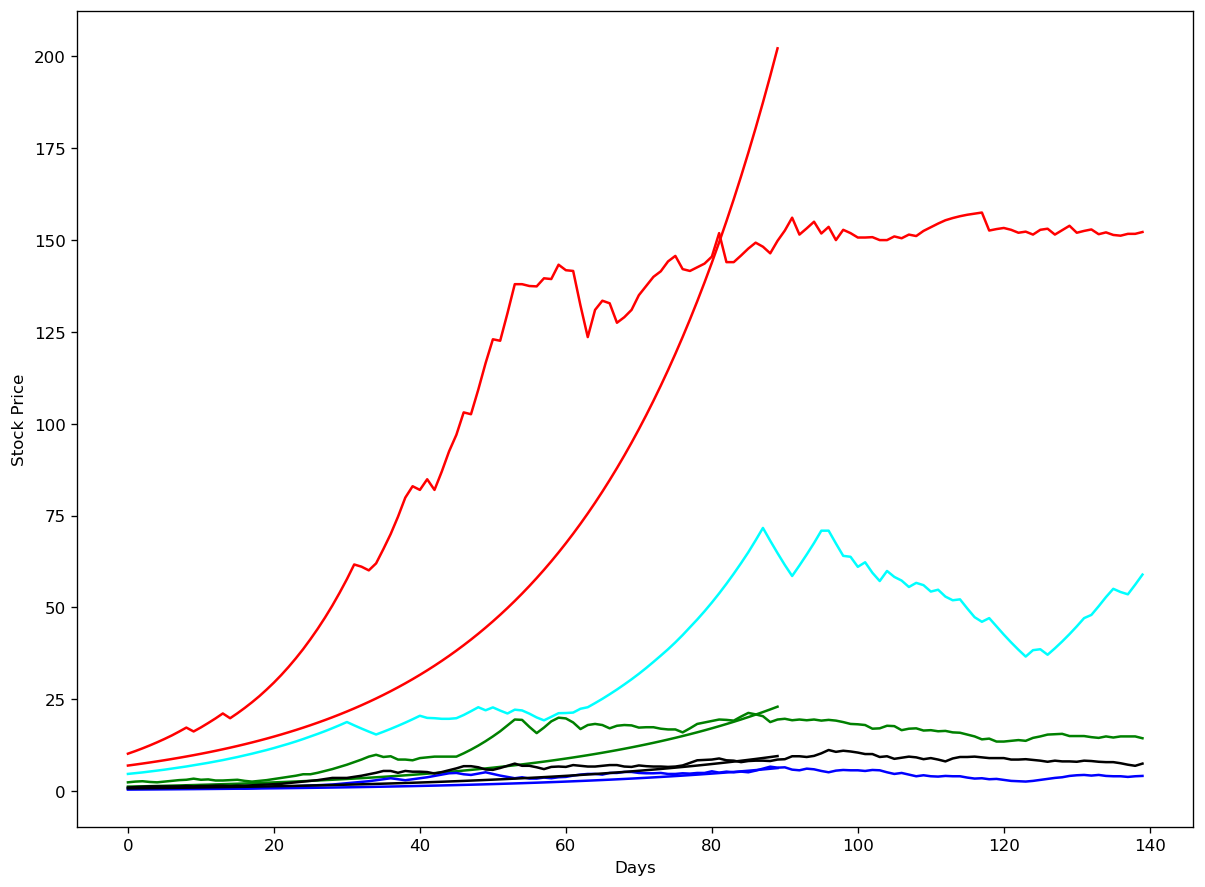

In [ ]:
plt.figure(figsize=(12, 5))
plt.xlabel('Days')
plt.ylabel('Stock Price')
colors = ['red','green','blue','cyan','black']
bests = momentums.max().sort_values(ascending=False).index[:5]
for color, best in zip(colors,bests):
    end = momentums[best].index.get_loc(momentums[best].idxmax())
    rets = np.log(close[best].iloc[end - 90 : end])
    x = np.arange(len(rets)) #90 days
    slope, intercept, r_value, p_value, std_err = linregress(x, rets)
    plt.plot(np.arange(140), close[best][end-70:end+70], color=color)
    plt.plot(x, np.e ** (intercept + slope*x), color=color)

#### Cross sectional analysis

In [ ]:
df.set_index('date') # Set the date as the index so we can add the index mean retrun for that day

df['index_mean_simple_return'] =  df.groupby('date')['simple_return'].apply(lambda x: x.mean())#We are using apply here instead of transform because apply can handle grouped outputs 

df['index_mean_log_return'] =  df.groupby('date')['log_return'].apply(lambda x: x.mean())

df['demeaned_return']  = df['simple_return'] - df['index_mean_simple_return']
df['demeaned_log_return']  = df['log_return'] - df['index_mean_log_return']

df.reset_index(inplace=True)#Reset index making the date a column again (lets us use it in calculations)

In [ ]:
df['3m'] = np.log(1 + df.groupby('ticker')['close'].pct_change(periods = 60))
df['12m'] = np.log(1 + df.groupby('ticker')['close'].pct_change(periods = 220))

In [ ]:
df['target-1'] = df.groupby('ticker')['close'].transform(lambda target: np.log(target.shift(-1)/target)) #One day ahead
df['target-2'] = df.groupby('ticker')['close'].transform(lambda target: np.log(target.shift(-5)/target)) #One week ahead
df['target-3'] = df.groupby('ticker')['close'].transform(lambda target: np.log(target.shift(-20)/target)) #One month ahead
df['target-4'] = df.groupby('ticker')['close'].transform(lambda target: np.log(target.shift(-60)/target)) #One quarter ahead
df['target-5'] = df.groupby('ticker')['close'].transform(lambda target: np.log(target.shift(-120)/target)) #One half ahead

In [ ]:
df.head(2)

index       date      open      high       low     close  volume  \
0      0 2009-12-30  8.132920  8.132920  6.099690  6.912982  140500   
1      1 2009-12-31  7.034976  7.034976  7.034976  7.034976   48900   

   unadjusted  putthrough ticker  ...  index_mean_log_return  demeaned_return  \
0        17.0           0    AMV  ...                    NaN              NaN   
1        17.3           0    AMV  ...                    NaN              NaN   

   demeaned_log_return  3m  12m  target-1  target-2  target-3  target-4  \
0                  NaN NaN  NaN  0.017493  0.132060 -0.131852 -0.152192   
1                  NaN NaN  NaN  0.067064  0.114567 -0.156079 -0.142656   

   target-5  
0 -0.042048  
1 -0.090697  

[2 rows x 26 columns]

In [ ]:
momentum_factor = pd.pivot_table(df,index='3m',values=['target-1','target-2','target-3','target-4','target-5'],aggfunc='mean')

In [ ]:
momentum_factor.head()

target-1  target-2  target-3  target-4  target-5
3m                                                         
-inf            inf       inf       inf       inf       inf
-2.794760  0.063179  0.322399  0.265703  0.083382  0.330242
-2.759343  0.051293  0.351398  0.456758  0.793231  1.044545
-2.724914  0.064220  0.206682  0.189945  0.005089  0.327687
-2.723164 -0.068268  0.189067  0.265872  0.030002  0.209858

In [ ]:
df['3m_bucket'] = functions.bucketing_factors(df['3m'],10)
df['12m_bucket'] = functions.bucketing_factors(df['12m'],10)

<AxesSubplot:title={'center':'Factor of 3m_bucket'}, xlabel='3m_bucket'>

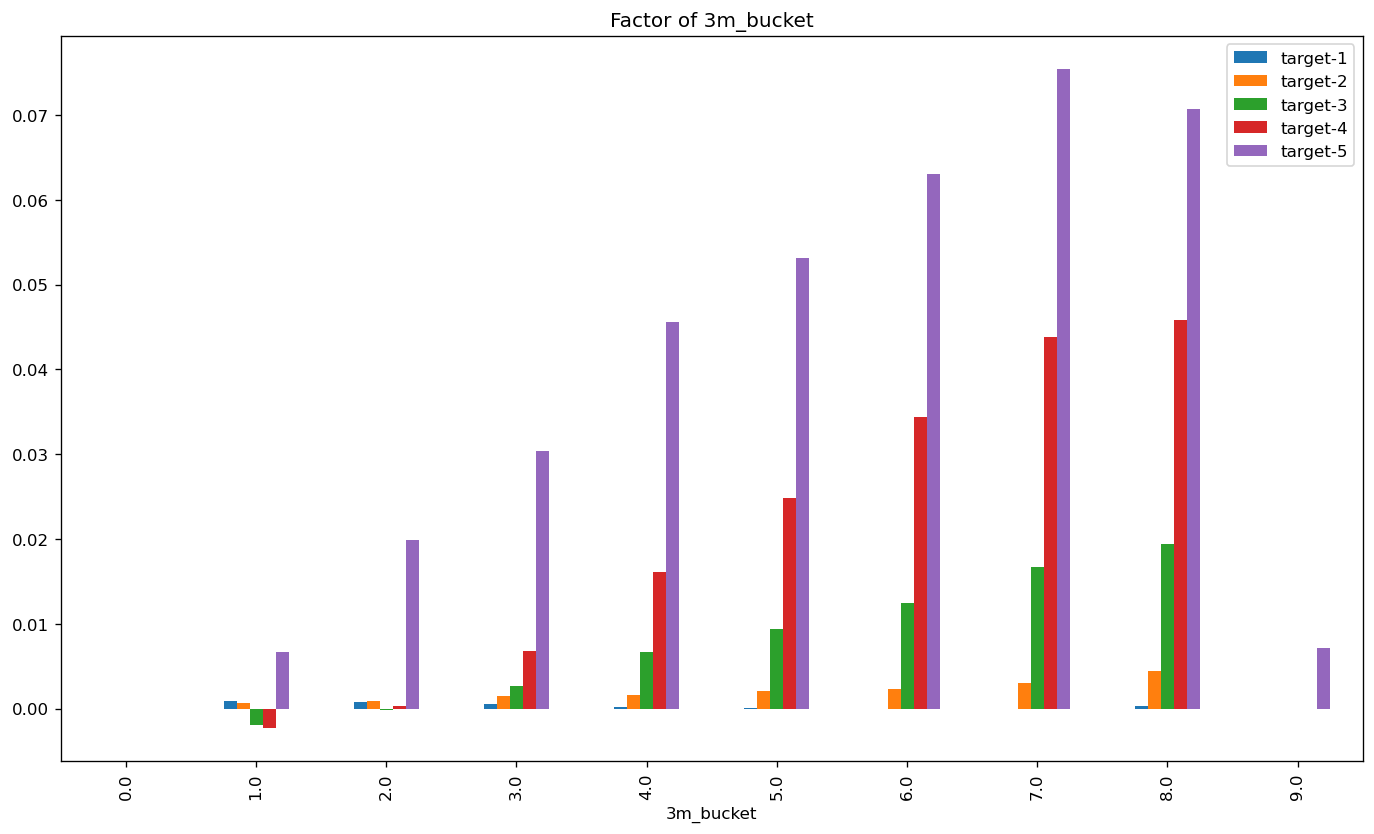

In [ ]:
visualizations.plot_bar(df, '3m_bucket')

<AxesSubplot:title={'center':'Factor of 12m_bucket'}, xlabel='12m_bucket'>

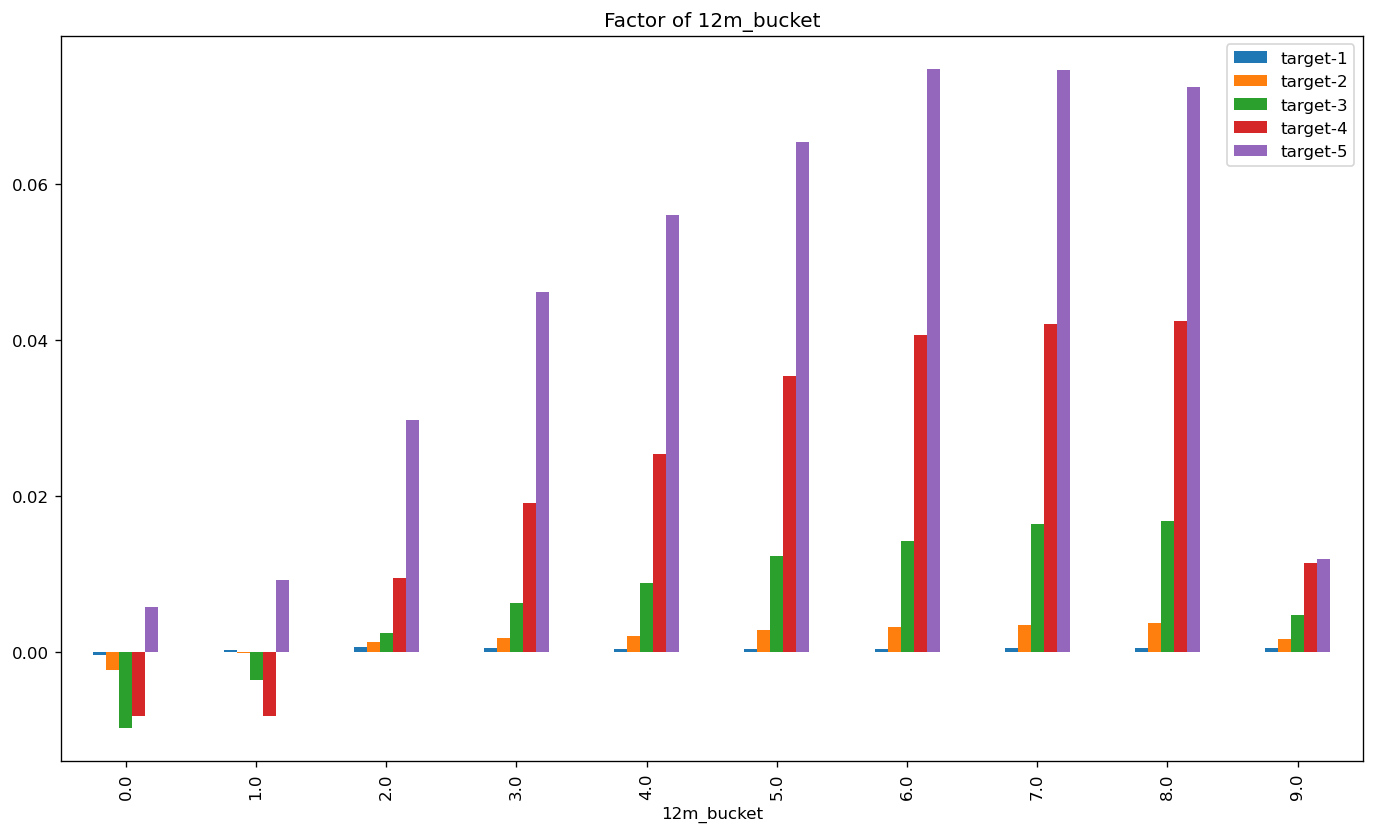

In [ ]:
visualizations.plot_bar(df, '12m_bucket')

In [ ]:
momen_factor_year = pd.pivot_table(df,index=['3m_bucket','year'],values='target-1',aggfunc='mean').reset_index()

In [ ]:
momen_factor_year['annualised'] = momen_factor_year['target-1']*252

In [ ]:
#10 quantiles in 16 years
print(momen_factor_year)

     3m_bucket  year  target-1  annualised
0          0.0  2006  0.000246    0.061890
1          0.0  2007  0.001490    0.375406
2          0.0  2008 -0.005826   -1.468137
3          0.0  2009  0.001976    0.498064
4          0.0  2010       inf         inf
..         ...   ...       ...         ...
155        9.0  2017  0.000474    0.119559
156        9.0  2018 -0.002566   -0.646689
157        9.0  2019 -0.001503   -0.378762
158        9.0  2020 -0.000166   -0.041738
159        9.0  2021  0.002292    0.577613

[160 rows x 4 columns]


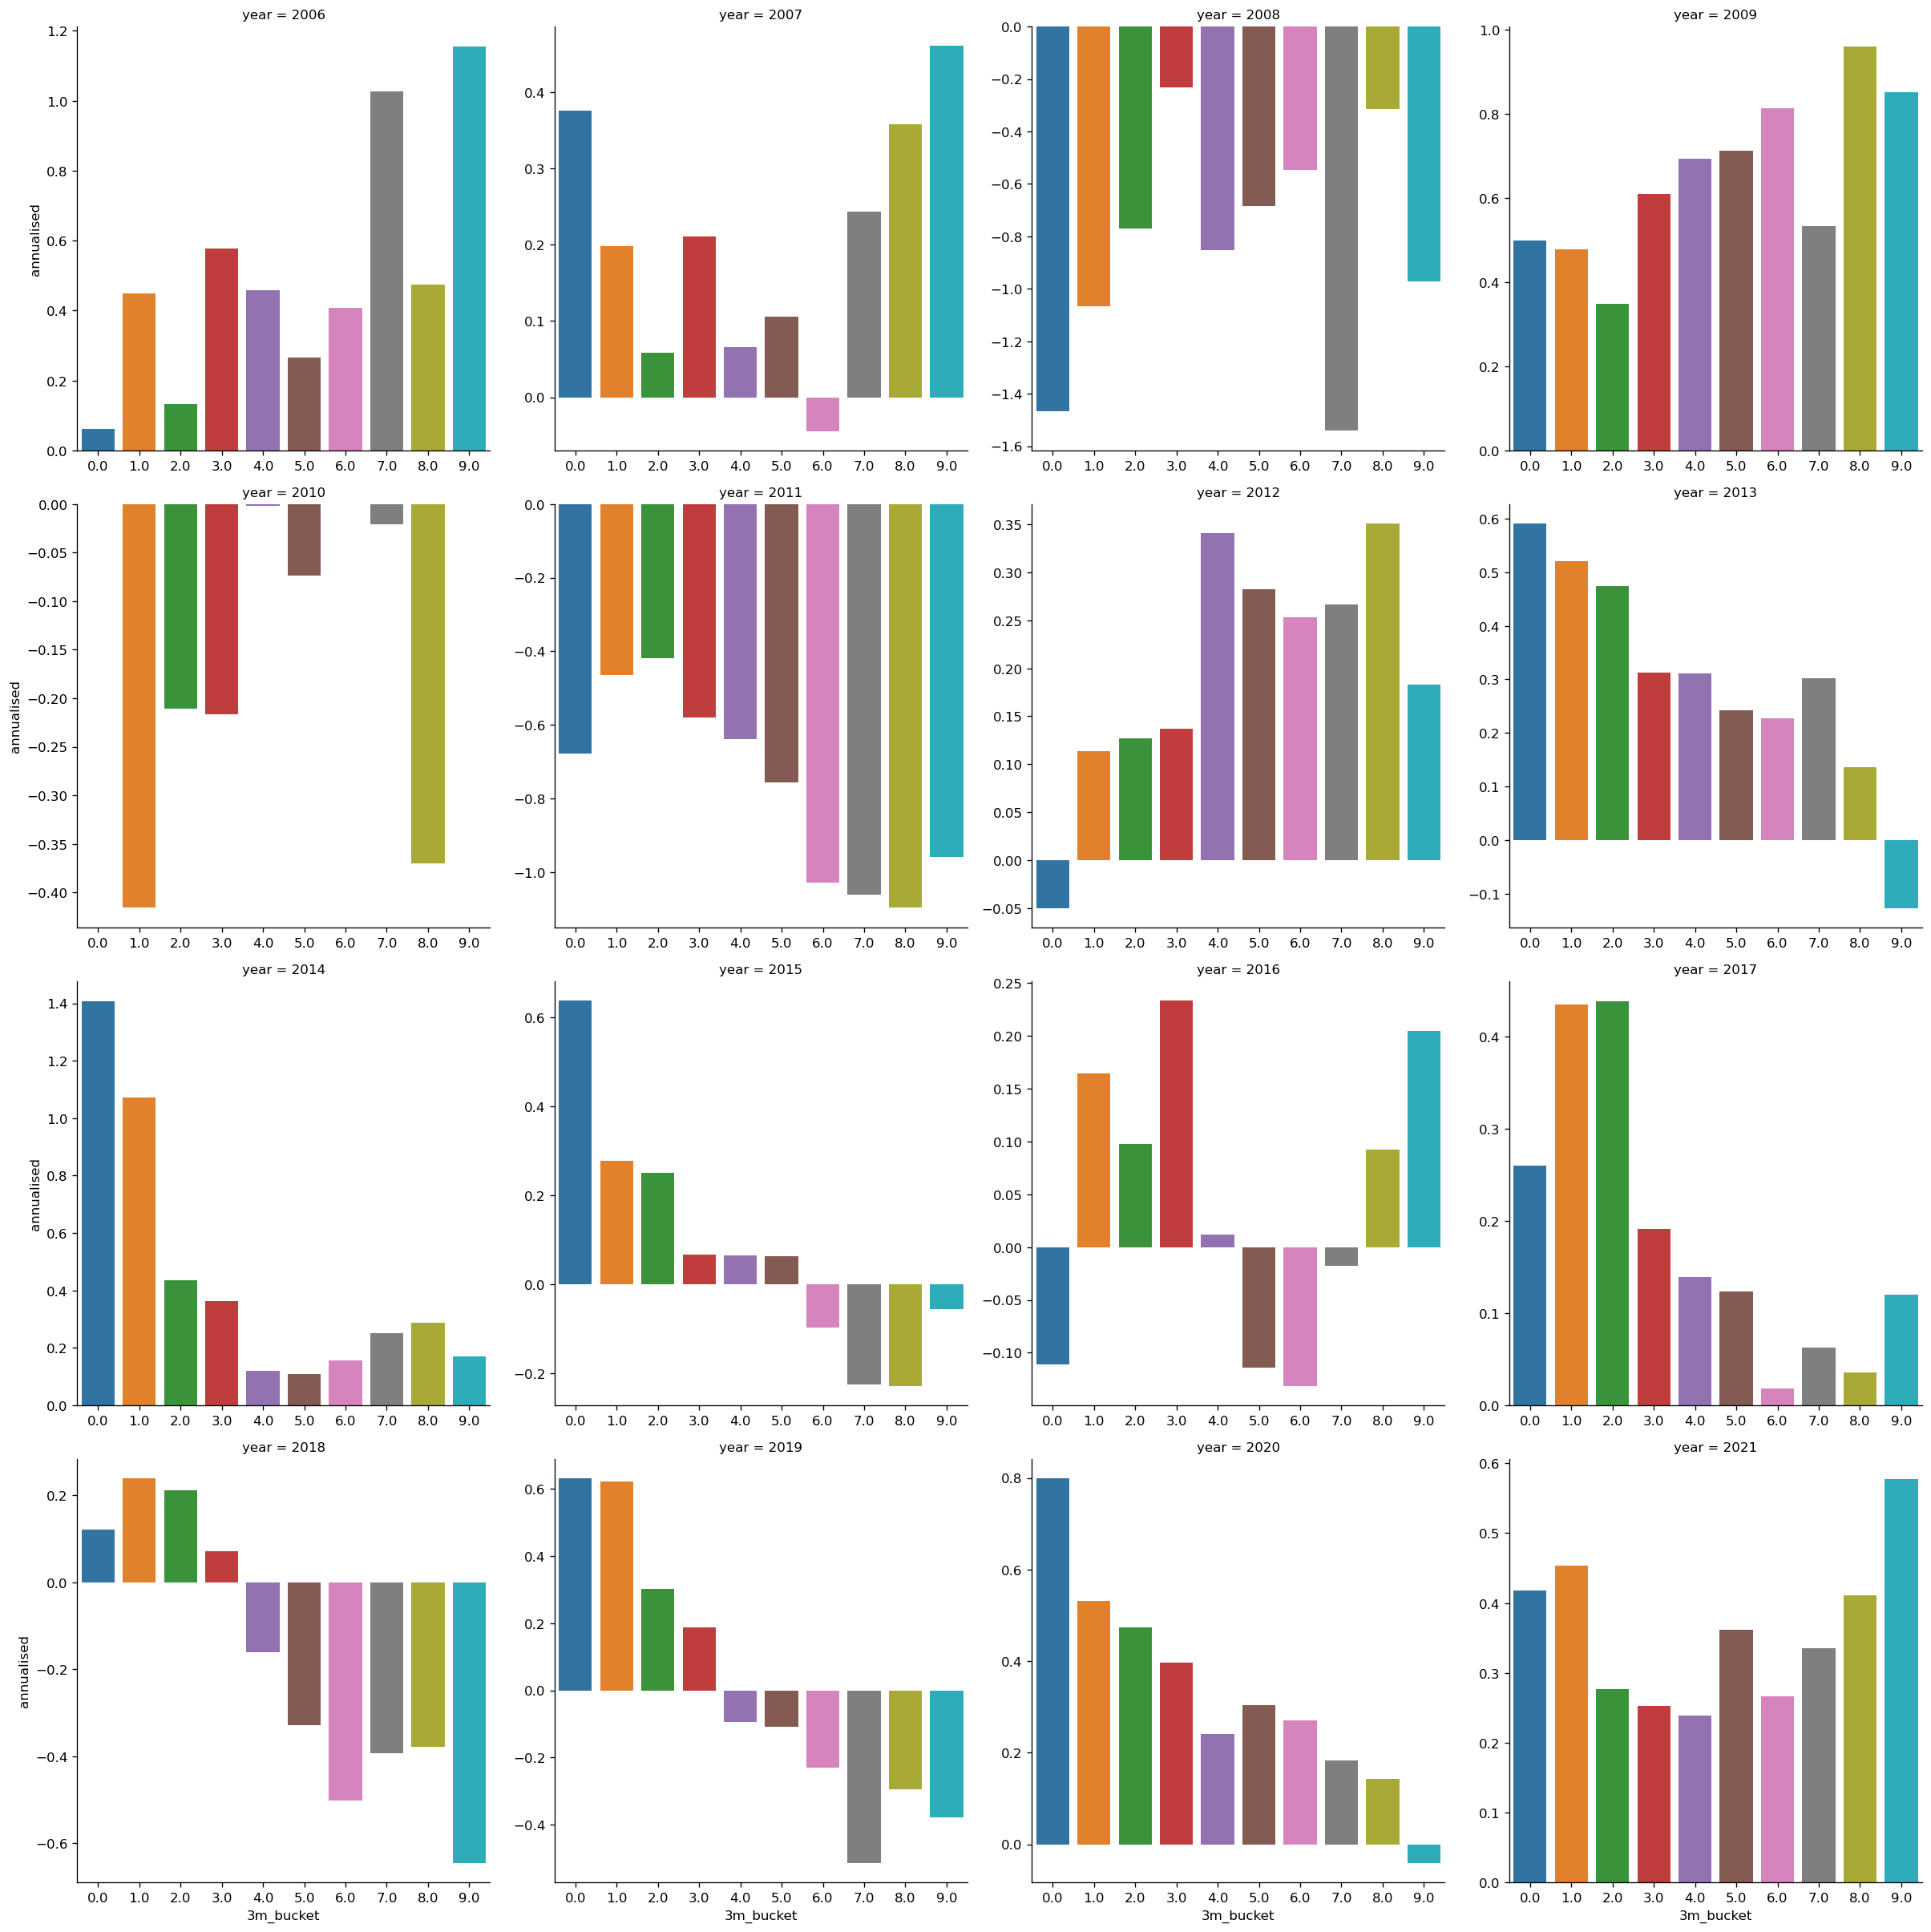

In [ ]:
sns.catplot(x='3m_bucket',y='annualised',data=momen_factor_year,kind='bar',col='year',col_wrap=4,sharey=False,sharex=False);

### Hypothesis refinement

Weekly,monthly, quarterly, halfly & yearly momentum indicators have been observed both in time series & cross sectional analysis, they are considered as the long-term alpha factors. The other indicators such as mean reversion & overnight sentiment - seasonality, both are short-time factors, are also taken into account in the model.

<h2>3. Model construction</h2>

A typical momentum strategy will buy stocks that have been showing an upward trend in hopes that the trend will continue and sell stocks showing a weak upward trend, even downward one in a specific time window. Momentum indicator is only used for ranking the stocks, not for price prediction.  
Momentum is almost the opposite of mean-reversion effect, accompany with seasonality as the key factors for portfolio alpha model.  
Alpha model operating under risk factors & weight scheme influences will be a real-world portfolio simulation (backtest). The model outcomes then are qualtified by perfomance metrics, by that investors/portfolio managers quantitatively make up their decision

### Candidate selection
This is a pretty high level research covering the whole VN stock exchange, so the project will handle 621 exchange-traded stocks, take 10 years historic data from 2011-09-01 to 2021-09-01

<h3>Quantopian zipline & alphalens</h3>
<h4>Zipline data ingestion & bundle construction</h4>


##### Data Bundle
We'll be using Zipline to handle our data. We've created a end of day data bundle for this project. Run the cell below to register this data bundle in zipline.

In [ ]:
from zipline.data import bundles
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar
from zipline.data.data_portal import DataPortal
import functions

os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), 'data', 'project_4_eod')

ingest_func = bundles.csvdir.csvdir_equities(['daily'], 'eod-quotemedia')
bundles.register('eod-quotemedia', ingest_func)

print('Data Registered')

Data Registered


#### Build Pipeline Engine
We'll be using Zipline's pipeline package to access our data for this project. To use it, we must build a pipeline engine. Run the cell below to build the engine.

In [ ]:
universe = AverageDollarVolume(window_length=120).top(621) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load('eod-quotemedia')
engine = functions.build_pipeline_engine(bundle_data, trading_calendar)

With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using. We'll use these tickers to generate the returns data for the our risk model.

In [ ]:
universe_end_date = pd.Timestamp('2021-09-01', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [AAA]),
 Equity(1 [AAV]),
 Equity(2 [ABC]),
 Equity(3 [ABI]),
 Equity(4 [ABS]),
 Equity(5 [ABT]),
 Equity(6 [ACB]),
 Equity(7 [ACC]),
 Equity(8 [ACE]),
 Equity(9 [ACL]),
 Equity(10 [ACM]),
 Equity(11 [ACV]),
 Equity(12 [ADG]),
 Equity(13 [ADS]),
 Equity(14 [AFX]),
 Equity(15 [AGG]),
 Equity(16 [AGM]),
 Equity(17 [AGR]),
 Equity(18 [AMD]),
 Equity(19 [AMS]),
 Equity(20 [AMV]),
 Equity(21 [ANV]),
 Equity(22 [APC]),
 Equity(23 [APF]),
 Equity(24 [APG]),
 Equity(25 [APS]),
 Equity(26 [ART]),
 Equity(27 [ASM]),
 Equity(28 [ASP]),
 Equity(29 [AST]),
 Equity(30 [ATB]),
 Equity(31 [ATG]),
 Equity(32 [BAB]),
 Equity(33 [BAX]),
 Equity(34 [BBC]),
 Equity(35 [BCC]),
 Equity(36 [BCE]),
 Equity(37 [BCG]),
 Equity(38 [BCM]),
 Equity(39 [BDG]),
 Equity(40 [BDT]),
 Equity(41 [BFC]),
 Equity(42 [BHN]),
 Equity(43 [BIC]),
 Equity(44 [BID]),
 Equity(45 [BII]),
 Equity(46 [BMC]),
 Equity(47 [BMI]),
 Equity(48 [BMP]),
 Equity(49 [BOT]),
 Equity(50 [BPW]),
 Equity(51 [BSA]),
 Equity(52 [BSI]),
 Eq

#### Get Prices & Returns
Building a data portal from pipeline engine.

In [ ]:
data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

To make the code easier to read, we've built the helper function `get_pricing` to get the pricing from the data portal. 

In [ ]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

Get daily returns for our risk model using the `get_pricing` function. For this model, we'll be looking back to 5 years of data.

In [ ]:
ten_year_prices = get_pricing(
        data_portal,trading_calendar,universe_tickers,
        universe_end_date - pd.DateOffset(years=10),
        universe_end_date)

In [ ]:
tickers = list(ten_year_prices.columns)
nan_val = {}
for name, close in ten_year_prices.iteritems():
  nan_val.update({name: close.index.get_loc(close.first_valid_index())})

In [ ]:
non_nan = {k: v for k, v in nan_val.items() if v < 1086}
ten_year_prices_418 = ten_year_prices[list(non_nan.keys())]

In [ ]:
# ten_year_returns = ten_year_prices_418.pct_change()[1:].fillna(0)
ten_year_returns = ten_year_prices.pct_change()[1:].fillna(0)
ten_year_returns.tail(2)

Equity(0 [AAA])  Equity(1 [AAV])  Equity(2 [ABC])  \
2021-08-31 00:00:00+00:00       0.00255754       0.06572770       0.04687500   
2021-09-01 00:00:00+00:00       0.03316327       0.09251101       0.03731343   

                           Equity(3 [ABI])  Equity(4 [ABS])  Equity(5 [ABT])  \
2021-08-31 00:00:00+00:00      -0.02548726      -0.02222222       0.00000000   
2021-09-01 00:00:00+00:00      -0.00769231       0.01262626       0.00000000   

                           Equity(6 [ACB])  Equity(7 [ACC])  Equity(8 [ACE])  \
2021-08-31 00:00:00+00:00      -0.00466563       0.00996678       0.00000000   
2021-09-01 00:00:00+00:00       0.00000000       0.01315789       0.01351351   

                           Equity(9 [ACL])        ...          \
2021-08-31 00:00:00+00:00       0.00778210        ...           
2021-09-01 00:00:00+00:00      -0.01158301        ...           

                           Equity(611 [VTO])  Equity(612 [VTP])  \
2021-08-31 00:00:00+00:00        -0.02764977        -0.00488400   
2021-09-01 00:00:00+00:00         0.02843602         0.00245399   

                           Equity(613 [VTR])  Equity(614 [VXP])  \
2021-08-31 00:00:00+00:00        -0.00331126         0.00000000   
2021-09-01 00:00:00+00:00         0.00000000         0.00000000   

                           Equity(615 [WCS])  Equity(616 [WSB])  \
2021-08-31 00:00:00+00:00         0.01104972         0.01836735   
2021-09-01 00:00:00+00:00        -0.01092896        -0.00801603   

                           Equity(617 [X26])  Equity(618 [YBM])  \
2021-08-31 00:00:00+00:00         0.00000000         0.00000000   
2021-09-01 00:00:00+00:00         0.00000000         0.03943662   

                           Equity(619 [YEG])  Equity(620 [YTC])  
2021-08-31 00:00:00+00:00         0.02287582         0.00000000  
2021-09-01 00:00:00+00:00        -0.00319489         0.00000000  

[2 rows x 621 columns]

### 3.1. Statistical Risk Model
Under CAPM theory, let's build a statistical risk model using PCA. So, the first thing is building the PCA model.

In [ ]:
import risk_model_funcs as rmf

#### Fit PCA
Implement `fit_pca` to fit a PCA model to the returns data

Let's see what the model looks like. First, we'll look at the PCA components.

In [ ]:
num_factor_exposures = 20 
pca = rmf.fit_pca(ten_year_returns, num_factor_exposures, 'full') #fit_pca compute factor exposure = pca.component_

pca.components_.shape #20 is num of rows (observations) which is reduced from 1256rows before PCA

(20, 621)

Let's also look at the PCA's percent of variance explained by each factor

<Container object of 20 artists>

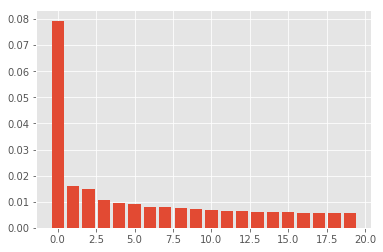

In [ ]:
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_)

The first factor/principal comonent dominates. The precise definition of each factor in a latent model is unknown, however we can see the contribution of stocks in each component.

In [ ]:
#Find the tickers contribute the most to the first principal component
top5_pc1 = np.argpartition(pca.components_[0], -5)[-5:]
print(top5_pc1,'\n', pca.components_[0][top5_pc1])

[467  59 617  50 491] 
 [0.0019516  0.00210761 0.00657672 0.00284012 0.0024031 ]


In [ ]:
ten_year_returns[top5_pc1].columns

Index([Equity(467 [STH]),  Equity(59 [BTV]), Equity(617 [X26]),
        Equity(50 [BPW]), Equity(491 [TDP])],
      dtype='object')

#### Factor Betas (factor exposure)

Implement `factor_betas` to get the factor betas from the PCA model.

In [ ]:
#risk_model: factor_betas,factor_returns,factor_cov_matrix,idiosyncratic_var_matrix,idiosyncratic_var_vector
risk_model = {}
#factor_betas(pca, factor_beta_indices, factor_beta_columns)
risk_model['factor_betas'] = rmf.factor_betas(pca, ten_year_returns.columns.values, np.arange(num_factor_exposures))

risk_model['factor_betas'] # 621(tickers) rows & 20(factors) columns

0           1           2           3           4   \
Equity(0 [AAA])   -0.06636663 -0.01670205 -0.00634937  0.00095639  0.00358794   
Equity(1 [AAV])   -0.04698247 -0.00374628 -0.00555477 -0.00274319 -0.00407468   
Equity(2 [ABC])   -0.03468384 -0.01215857 -0.02576420 -0.01569808  0.00806092   
Equity(3 [ABI])   -0.02684912 -0.00921740 -0.03028402 -0.00735029  0.01148562   
Equity(4 [ABS])   -0.01549416  0.00077915 -0.00204996 -0.00823641  0.00698126   
Equity(5 [ABT])   -0.01389614 -0.01831203 -0.00063227  0.00050106  0.00004280   
Equity(6 [ACB])   -0.05784458 -0.03037018 -0.00752071  0.01291441 -0.01355762   
Equity(7 [ACC])   -0.02093755 -0.00742522 -0.01703242 -0.02041100 -0.00923338   
Equity(8 [ACE])   -0.00860667  0.01261540  0.00741267  0.00645763  0.00885967   
Equity(9 [ACL])   -0.03517538 -0.00929044  0.00355026 -0.01059080  0.00986346   
Equity(10 [ACM])  -0.07797920  0.44295748  0.59092236 -0.35636135  0.04281473   
Equity(11 [ACV])  -0.04179341 -0.02488253 -0.00833552 -0.00784949 -0.00564183   
Equity(12 [ADG])  -0.01226365 -0.00370099  0.00130475 -0.00224750  0.00024793   
Equity(13 [ADS])  -0.01760076 -0.02329843 -0.00704451 -0.00019237  0.00147122   
Equity(14 [AFX])  -0.04557925 -0.05313783  0.00242575 -0.03827377 -0.03696697   
Equity(15 [AGG])  -0.01394035 -0.00557821 -0.00463125 -0.00166617  0.00086338   
Equity(16 [AGM])  -0.01984948 -0.00838427  0.00843913 -0.00079970  0.01434605   
Equity(17 [AGR])  -0.06944481 -0.00197670 -0.00353236 -0.00278618  0.00492469   
Equity(18 [AMD])  -0.05705288  0.04190733  0.01396414 -0.01645960 -0.00412723   
Equity(19 [AMS])  -0.02523883  0.04085441 -0.03762924 -0.01393216 -0.01489138   
Equity(20 [AMV])  -0.05278799 -0.02745368 -0.00275599  0.00409558  0.00569188   
Equity(21 [ANV])  -0.05914880 -0.02810508 -0.00348932 -0.00846532  0.01531561   
Equity(22 [APC])  -0.04798985 -0.00805296 -0.00582432 -0.01336106  0.00521314   
Equity(23 [APF])  -0.01385324 -0.01234884 -0.00597076  0.01516439  0.00551070   
Equity(24 [APG])  -0.04622798 -0.00416072 -0.01479339  0.00336370  0.01268699   
Equity(25 [APS])  -0.06099672  0.03232112 -0.01852803 -0.01474698 -0.01379980   
Equity(26 [ART])  -0.08882702  0.05545873  0.00568228  0.00736934  0.00389992   
Equity(27 [ASM])  -0.06944663 -0.00906608  0.00993389  0.00274682  0.00885558   
Equity(28 [ASP])  -0.03419569 -0.00577131 -0.00434977 -0.00172248 -0.00131766   
Equity(29 [AST])  -0.03262825 -0.01967053 -0.00358072 -0.01583936  0.00373819   
...                       ...         ...         ...         ...         ...   
Equity(591 [VNS]) -0.02352875 -0.00396729 -0.00580703 -0.01184821 -0.00187556   
Equity(592 [VNT])  0.00295404  0.00039527  0.03744647  0.00579784  0.02045064   
Equity(593 [VOC]) -0.03644552 -0.01087880 -0.00977884 -0.00133700 -0.03595618   
Equity(594 [VOS]) -0.05428282  0.01662058 -0.00238696 -0.00130469  0.00954013   
Equity(595 [VPB]) -0.06084013 -0.02455535 -0.00413468  0.00812355 -0.00383298   
Equity(596 [VPD]) -0.01565677 -0.00571034  0.00367884 -0.00223214 -0.00888856   
Equity(597 [VPG]) -0.02048755 -0.00660647 -0.00445080 -0.01266879 -0.00066697   
Equity(598 [VPH]) -0.04842641  0.01198633  0.00442776 -0.01316972  0.00229943   
Equity(599 [VPI]) -0.01532846 -0.00555974 -0.00515658 -0.00388310  0.00363954   
Equity(600 [VPK]) -0.00427035 -0.00143303 -0.00083867  0.01958065  0.03282947   
Equity(601 [VRC]) -0.05897885 -0.00231283 -0.00360864 -0.00475460 -0.01363761   
Equity(602 [VRE]) -0.05056651 -0.02075245  0.00016591  0.00207889  0.00033405   
Equity(603 [VRG]) -0.04366826  0.01096076  0.02110796  0.03042938 -0.01753810   
Equity(604 [VSC]) -0.04088612 -0.02940680 -0.00120203  0.01111904  0.00727462   
Equity(605 [VSH]) -0.01985886 -0.00568278 -0.00652964 -0.00058694  0.00194303   
Equity(606 [VSI]) -0.01252165 -0.01731634  0.01129384 -0.01256361  0.00254048   
Equity(607 [VSN]) -0.02973295 -0.02019870  0.01547293  0.00361004 -0.00537384   
Equity(608 [VTB]) -0.01532179  0.01210176  0.01178307 -0.0

#### Factor Returns from asset returns
Implement `factor_returns` to get the factor returns from the PCA model using the returns data.

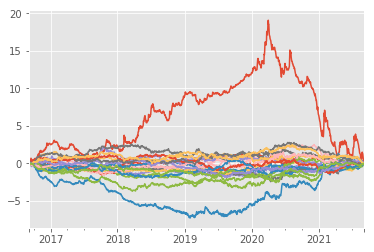

In [ ]:
#factor_returns(pca, returns, factor_return_indices, factor_return_columns)
risk_model['factor_returns'] = rmf.factor_returns(
    pca,
    ten_year_returns,
    ten_year_returns.index,
    np.arange(num_factor_exposures))

risk_model['factor_returns'].cumsum().plot(legend=None) # 20 PCs (factors) returns by time (1256days)

#### Factor Covariance Matrix
Implement `factor_cov_matrix` to get the factor covariance matrix.

In [ ]:
ann_factor = 252
risk_model['factor_cov_matrix'] = rmf.factor_cov_matrix(risk_model['factor_returns'], ann_factor)

risk_model['factor_cov_matrix']

array([[11.15417888,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  2.44194947,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  2.15418853,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  2.00468015,  0.        ,
         0.        ,  0.        ,  0.        ,  

In [ ]:
np.shape(risk_model['factor_cov_matrix'])

(20, 20)

#### Idiosyncratic Variance Matrix (specific return)
Implement `idiosyncratic_var_matrix` to get the idiosyncratic variance matrix.

In [ ]:
#idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor)
risk_model['idiosyncratic_var_matrix'] = rmf.idiosyncratic_var_matrix(ten_year_returns, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)

risk_model['idiosyncratic_var_matrix']

Equity(0 [AAA])  Equity(1 [AAV])  Equity(2 [ABC])  \
Equity(0 [AAA])         0.08393465       0.00000000       0.00000000   
Equity(1 [AAV])         0.00000000       0.16290442       0.00000000   
Equity(2 [ABC])         0.00000000       0.00000000       0.27225524   
Equity(3 [ABI])         0.00000000       0.00000000       0.00000000   
Equity(4 [ABS])         0.00000000       0.00000000       0.00000000   
Equity(5 [ABT])         0.00000000       0.00000000       0.00000000   
Equity(6 [ACB])         0.00000000       0.00000000       0.00000000   
Equity(7 [ACC])         0.00000000       0.00000000       0.00000000   
Equity(8 [ACE])         0.00000000       0.00000000       0.00000000   
Equity(9 [ACL])         0.00000000       0.00000000       0.00000000   
Equity(10 [ACM])        0.00000000       0.00000000       0.00000000   
Equity(11 [ACV])        0.00000000       0.00000000       0.00000000   
Equity(12 [ADG])        0.00000000       0.00000000       0.00000000   
Equity(13 [ADS])        0.00000000       0.00000000       0.00000000   
Equity(14 [AFX])        0.00000000       0.00000000       0.00000000   
Equity(15 [AGG])        0.00000000       0.00000000       0.00000000   
Equity(16 [AGM])        0.00000000       0.00000000       0.00000000   
Equity(17 [AGR])        0.00000000       0.00000000       0.00000000   
Equity(18 [AMD])        0.00000000       0.00000000       0.00000000   
Equity(19 [AMS])        0.00000000       0.00000000       0.00000000   
Equity(20 [AMV])        0.00000000       0.00000000       0.00000000   
Equity(21 [ANV])        0.00000000       0.00000000       0.00000000   
Equity(22 [APC])        0.00000000       0.00000000       0.00000000   
Equity(23 [APF])        0.00000000       0.00000000       0.00000000   
Equity(24 [APG])        0.00000000       0.00000000       0.00000000   
Equity(25 [APS])        0.00000000       0.00000000       0.00000000   
Equity(26 [ART])        0.00000000       0.00000000       0.00000000   
Equity(27 [ASM])        0.00000000       0.00000000       0.00000000   
Equity(28 [ASP])        0.00000000       0.00000000       0.00000000   
Equity(29 [AST])        0.00000000       0.00000000       0.00000000   
...                            ...              ...              ...   
Equity(591 [VNS])       0.00000000       0.00000000       0.00000000   
Equity(592 [VNT])       0.00000000       0.00000000       0.00000000   
Equity(593 [VOC])       0.00000000       0.00000000       0.00000000   
Equity(594 [VOS])       0.00000000       0.00000000       0.00000000   
Equity(595 [VPB])       0.00000000       0.00000000       0.00000000   
Equity(596 [VPD])       0.00000000       0.00000000       0.00000000   
Equity(597 [VPG])       0.00000000       0.00000000       0.00000000   
Equity(598 [VPH])       0.00000000       0.00000000       0.00000000   
Equity(599 [VPI])       0.00000000       0.00000000       0.00000000   
Equity(600 [VPK])       0.00000000       0.00000000       0.00000000   
Equity(601 [VRC])       0.00000000       0.00000000       0.00000000   
Equity(602 [VRE])       0.00000000       0.00000000       0.00000000   
Equity(603 [VRG])       0.00000000       0.00000000       0.00000000   
Equity(604 [VSC])       0.00000000       0.00000000       0.00000000   
Equity(605 [VSH])       0.00000000       0.00000000       0.00000000   
Equity(606 [VSI])       0.00000000       0.00000000       0.00000000   
Equity(607 [VSN])       0.00000000       0.00000000       0.00000000   
Equity(608 [VTB])       0.00000000       0.00000000       0.00000000   
Equity(609 [VTD])       0.00000000       0.00000000       0.00000000   
Equity(610 [VTK])       0.00000000       0.00000000       0.00000000   
Equity(611 [VTO])       0.00000000       0.00000000       0.00000000   
Equity(612 [VTP])       0.00000000       0.00000000       0.00000000   
Equity(613 [VTR])       0.00000000       0.00000000       0.00000000   
Equity(614 [VXP])       0.00000000       0.00000000       0

#### Idiosyncratic Variance Vector
Implement `idiosyncratic_var_vector` to get the idiosyncratic variance Vector.

In [ ]:
#idiosyncratic_var_vector(returns, idiosyncratic_var_matrix)
risk_model['idiosyncratic_var_vector'] = rmf.idiosyncratic_var_vector(ten_year_returns, risk_model['idiosyncratic_var_matrix'])

risk_model['idiosyncratic_var_vector']

0
Equity(0 [AAA])   0.08393465
Equity(1 [AAV])   0.16290442
Equity(2 [ABC])   0.27225524
Equity(3 [ABI])   0.31215900
Equity(4 [ABS])   0.10675570
Equity(5 [ABT])   0.16046434
Equity(6 [ACB])   0.04957656
Equity(7 [ACC])   0.09979946
Equity(8 [ACE])   0.34062986
Equity(9 [ACL])   0.16255027
Equity(10 [ACM])  0.04730749
Equity(11 [ACV])  0.09487031
Equity(12 [ADG])  0.02527266
Equity(13 [ADS])  0.10404557
Equity(14 [AFX])  0.57438250
Equity(15 [AGG])  0.01707578
Equity(16 [AGM])  0.19126205
Equity(17 [AGR])  0.14038508
Equity(18 [AMD])  0.19795734
Equity(19 [AMS])  0.50908491
Equity(20 [AMV])  0.21948003
Equity(21 [ANV])  0.18440230
Equity(22 [APC])  0.15720980
Equity(23 [APF])  0.20223567
Equity(24 [APG])  0.20955491
Equity(25 [APS])  0.25167778
Equity(26 [ART])  0.39218456
Equity(27 [ASM])  0.11560901
Equity(28 [ASP])  0.10271821
Equity(29 [AST])  0.06645927
...                      ...
Equity(591 [VNS]) 0.12021084
Equity(592 [VNT]) 0.51794448
Equity(593 [VOC]) 0.21254664
Equity(594 [VOS]) 0.24226085
Equity(595 [VPB]) 0.06221017
Equity(596 [VPD]) 0.08766494
Equity(597 [VPG]) 0.09941151
Equity(598 [VPH]) 0.12882520
Equity(599 [VPI]) 0.02257334
Equity(600 [VPK]) 0.25275391
Equity(601 [VRC]) 0.21305250
Equity(602 [VRE]) 0.07457136
Equity(603 [VRG]) 0.37451652
Equity(604 [VSC]) 0.07314583
Equity(605 [VSH]) 0.05879187
Equity(606 [VSI]) 0.22848754
Equity(607 [VSN]) 0.26951254
Equity(608 [VTB]) 0.27148379
Equity(609 [VTD]) 0.12347451
Equity(610 [VTK]) 0.16924350
Equity(611 [VTO]) 0.05744002
Equity(612 [VTP]) 0.05315246
Equity(613 [VTR]) 0.08547475
Equity(614 [VXP]) 0.09350185
Equity(615 [WCS]) 0.16233761
Equity(616 [WSB]) 0.17499256
Equity(617 [X26]) 0.48202772
Equity(618 [YBM]) 0.14205238
Equity(619 [YEG]) 0.17178587
Equity(620 [YTC]) 0.54163328

[621 rows x 1 columns]

#### Predict using the Risk Model
Using the data we calculated in the risk model, implement `predict_portfolio_risk` to predict the portfolio risk using the formula $ \sqrt{X^{T}(BFB^{T} + S)X} $ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

Let's see what the portfolio risk would be if we had even weights across all stocks.

In [ ]:
#assume equal weight for every stock
all_weights = pd.DataFrame(np.repeat(1/len(universe_tickers), len(universe_tickers)), universe_tickers)

#predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights)
rmf.predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.11666319150394658

<h3>3.3. Alpha model</h3>

In [ ]:
import alpha_model_funcs as amf

### Create Alpha Factors
With the profile risk calculated, it's time to start working on the alpha factors. In this project, we'll create the following factors:
- Momentum 1 Year, Half Year, Quarter, 1 Month, 1 Week Factor
- Mean Reversion 5 Day Sector Neutral Factor
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Factor
- Overnight Sentiment Smoothed Factor  

Each factor will have a hypothesis that goes with it. 

#### Momentum Factor
- Yearly momentum hypothesis: it is "Higher past 12-months (252 days) returns are proportional to future return." 
- Halfly momentum hypothesis: it is "Higher past 6-months (120 days) returns are proportional to future return." 
- Quarterly momentum hypothesis: it is "Higher past 3-months (60 days) returns are proportional to future return." 
- Monthly momentum hypothesis: it is "Higher past 1-month (20 days) returns are proportional to future return." 
- Weekly momentum hypothesis: it is "Higher past 1-week (5 days) returns are proportional to future return." 

#### Mean Reversion 5 Day Factor
Mean_reversion_5day hypothesis "Short-term outperformers(underperformers) compared to their sector will revert." Use the returns data from `universe`, ranking, then converted to a zscore.

Let's see what some of the factor data looks like. For calculating factors, we'll be looking back 5 years.

**Note:** _Going back 5 years falls on a day when the market is closed. Pipeline package doesn't handle start or end dates that don't fall on days when the market is open. To fix this, we went back 2 extra days to fall on the next day when the market is open._

In [ ]:
factor_start_date = universe_end_date - pd.DateOffset(years=5, days=2)
window_length = 5

pipeline = Pipeline(screen=universe)
pipeline.add(
    amf.mean_reversion(window_length, universe),
    'Mean_Reversion_5Day')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

Mean_Reversion_5Day_Sector_Neutral
2019-08-30 00:00:00+00:00 Equity(0 [AAA])                            1.51305792
                          Equity(1 [AAV])                           -1.04093834
                          Equity(2 [ABC])                            0.99543284
                          Equity(3 [ABI])                           -0.97836828
                          Equity(4 [ABS])                                   nan
                          Equity(5 [ABT])                           -1.16607847
                          Equity(6 [ACB])                            0.75084077
                          Equity(7 [ACC])                           -0.05688188
                          Equity(8 [ACE])                           -0.70533527
                          Equity(9 [ACL])                            0.50056051
                          Equity(10 [ACM])                          -1.68939174
                          Equity(11 [ACV])                          -0.80772265
                          Equity(12 [ADG])                                  nan
                          Equity(13 [ADS])                           0.45505501
                          Equity(14 [AFX])                          -1.67801536
                          Equity(15 [AGG])                                  nan
                          Equity(16 [AGM])                          -0.06257006
                          Equity(17 [AGR])                          -1.21158397
                          Equity(18 [AMD])                           1.30259497
                          Equity(19 [AMS])                          -1.10919659
                          Equity(20 [AMV])                          -0.98974465
                          Equity(21 [ANV])                           0.76221715
                          Equity(22 [APC])                           0.61432427
                          Equity(23 [APF])                          -1.62113348
                          Equity(24 [APG])                           0.77359352
                          Equity(25 [APS])                           1.24002491
                          Equity(26 [ART])                           1.61544530
                          Equity(27 [ASM])                           0.40954951
                          Equity(28 [ASP])                          -1.45048785
                          Equity(29 [AST])                           1.06369109
...                                                                         ...
2021-09-01 00:00:00+00:00 Equity(591 [VNS])                         -0.54215832
                          Equity(592 [VNT])                         -1.25552453
                          Equity(593 [VOC])                         -1.15279980
                          Equity(594 [VOS])                         -1.55799180
                          Equity(595 [VPB])                          0.85033252
                          Equity(596 [VPD])                         -0.17120789
                          Equity(597 [VPG])                          0.17691482
                          Equity(598 [VPH])                          0.26251877
                          Equity(599 [VPI])                          0.91310875
                          Equity(600 [VPK])                                 nan
                          Equity(601 [VRC])                         -0.15979403
                          Equity(602 [VRE])                         -0.01141386
                          Equity(603 [VRG])                          1.24981760
                          Equity(604 [VSC])                          0.10272473
                          Equity(605 [VSH])                          1.23269681
                          Equity(606 [VSI])                         -1.53516408
                          Equity(607 [VSN])                         -0.35382964
                          Equity(608 [VTB])                          1.47809479
                          Equity(609 [VTD])  

#### Mean Reversion 5 Days Smoothed Factor
Taking the output of the previous factor, let's create a smoothed version. Implement `mean_reversion_5day_smoothed` to generate a mean reversion 5 days smoothed factor. Call the `mean_reversion_5day` function to get the unsmoothed factor, then use `SimpleMovingAverage` function to smooth it. It is also applied rank and zscore again.

Let's see what some of the smoothed data looks like.

In [ ]:
pipeline = Pipeline(screen=universe)
pipeline.add(
    amf.mean_reversion_smoothed(5, universe),
    'Mean_Reversion_5Day_Smoothed')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

Mean_Reversion_5Day_Sector_Neutral_Smoothed
2019-08-30 00:00:00+00:00 Equity(0 [AAA])                                     1.43342329
                          Equity(1 [AAV])                                     0.40954951
                          Equity(2 [ABC])                                     1.59838073
                          Equity(3 [ABI])                                    -0.29578576
                          Equity(4 [ABS])                                            nan
                          Equity(5 [ABT])                                    -1.48461698
                          Equity(6 [ACB])                                    -0.46074320
                          Equity(7 [ACC])                                    -0.52331326
                          Equity(8 [ACE])                                    -1.42204692
                          Equity(9 [ACL])                                     1.21727216
                          Equity(10 [ACM])                                   -1.43911148
                          Equity(11 [ACV])                                   -0.14789288
                          Equity(12 [ADG])                                           nan
                          Equity(13 [ADS])                                   -0.17633382
                          Equity(14 [AFX])                                   -1.71214449
                          Equity(15 [AGG])                                           nan
                          Equity(16 [AGM])                                   -0.22183932
                          Equity(17 [AGR])                                   -1.53581067
                          Equity(18 [AMD])                                   -0.87598090
                          Equity(19 [AMS])                                   -1.62113348
                          Equity(20 [AMV])                                    0.14789288
                          Equity(21 [ANV])                                    1.11488478
                          Equity(22 [APC])                                    1.50168154
                          Equity(23 [APF])                                    0.76221715
                          Equity(24 [APG])                                    1.21158397
                          Equity(25 [APS])                                    0.58019514
                          Equity(26 [ART])                                    1.09213203
                          Equity(27 [ASM])                                    0.38110857
                          Equity(28 [ASP])                                   -1.34241229
                          Equity(29 [AST])                                    0.21046294
...                                                                                  ...
2021-09-01 00:00:00+00:00 Equity(591 [VNS])                                   0.28633617
                          Equity(592 [VNT])                                   1.23517562
                          Equity(593 [VOC])                                  -0.80847859
                          Equity(594 [VOS])                                  -1.12288693
                          Equity(595 [VPB])                                   1.15657353
                          Equity(596 [VPD])                                  -0.24703512
                          Equity(597 [VPG])                                  -1.21833231
                          Equity(598 [VPH])                                   0.92638171
                          Equity(599 [VPI])                                   0.26387843
                          Equity(600 [VPK])                                          nan
                          Equity(601 [VRC])                                   1.29693440
                          Equity(602 [VRE])                                   0.30879390
                          Equity(603 [VRG])                                  -0.34809495
                          Equity(604 [VS

#### Overnight Sentiment Factor
For this factor, were using the hypothesis from the paper [_Overnight Returns and Firm-Specific Investor Sentiment_](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010).

#### Overnight Sentiment Smoothed Factor

#### Combine the Factors to a single Pipeline
With all the factor implementations done, let's add them to a pipeline.

In [ ]:
universe = AverageDollarVolume(window_length=120).top(621)

pipeline = Pipeline(screen=universe)
pipeline.add(
    amf.momentum(252, universe),
    'Momentum_1YR')
pipeline.add(
    amf.momentum(5, universe),
    'Momentum_1WK')
pipeline.add(
    amf.momentum(20, universe),
    'Momentum_1MNT')
pipeline.add(
    amf.momentum(60, universe),
    'Momentum_1QTR')
pipeline.add(
    amf.momentum(120, universe),
    'Momentum_1HLF')
pipeline.add(
    amf.mean_reversion(5, universe),
    'Mean_Reversion_5Day')
pipeline.add(
    amf.mean_reversion_smoothed(5, universe),
    'Mean_Reversion_5Day_Smoothed')
pipeline.add(
    amf.overnight_sentiment(2, 5, universe),
    'Overnight_Sentiment')
pipeline.add(
    amf.overnight_sentiment_smoothed(2, 5, universe),
    'Overnight_Sentiment_Smoothed')
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

all_factors.head()

Mean_Reversion_5Day_Sector_Neutral  \
2019-08-30 00:00:00+00:00 Equity(0 [AAA])                          1.51305792   
                          Equity(1 [AAV])                         -1.04093834   
                          Equity(2 [ABC])                          0.99543284   
                          Equity(3 [ABI])                         -0.97836828   
                          Equity(4 [ABS])                                 nan   

                                           Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
2019-08-30 00:00:00+00:00 Equity(0 [AAA])                                   1.43342329   
                          Equity(1 [AAV])                                   0.40954951   
                          Equity(2 [ABC])                                   1.59838073   
                          Equity(3 [ABI])                                  -0.29578576   
                          Equity(4 [ABS])                                          nan   

                                           Momentum_1HLF  Momentum_1MNT  \
2019-08-30 00:00:00+00:00 Equity(0 [AAA])    -0.08948942    -1.35886407   
                          Equity(1 [AAV])     1.07098624     0.87457289   
                          Equity(2 [ABC])     0.90932794    -0.44155960   
                          Equity(3 [ABI])     1.18068294     0.94294341   
                          Equity(4 [ABS])            nan            nan   

                                           Momentum_1QTR  Momentum_1WK  \
2019-08-30 00:00:00+00:00 Equity(0 [AAA])    -0.68937440   -1.51305792   
                          Equity(1 [AAV])     1.24087393    1.04093834   
                          Equity(2 [ABC])     0.93640023   -0.99543284   
                          Equity(3 [ABI])     1.29832179    0.97836828   
                          Equity(4 [ABS])            nan           nan   

                                           Momentum_1YR  Overnight_Sentiment  \
2019-08-30 00:00:00+00:00 Equity(0 [AAA])   -0.56037022          -0.09483060   
                          Equity(1 [AAV])   -1.02784484           0.44068339   
                          Equity(2 [ABC])    0.30265985          -0.02231308   
                          Equity(3 [ABI])    0.56636348           1.68463775   
                          Equity(4 [ABS])           nan           0.00557827   

                                           Overnight_Sentiment_Smoothed  
2019-08-30 00:00:00+00:00 Equity(0 [AAA])                    0.29007008  
                          Equity(1 [AAV])                   -0.08925233  
                          Equity(2 [ABC])                    0.77537963  
                          Equity(3 [ABI])                    1.67905948  
                          Equity(4 [ABS])                   -0.07809579

### Evaluate Alpha Factors
*Note:* _We're evaluating the alpha factors using delay of 1_

In [ ]:
import alphalens as al

assets = all_factors.index.levels[1].values.tolist() # get index from alpha fattors
pricing = get_pricing(
    data_portal,
    trading_calendar,
    assets, 
    factor_start_date,
    universe_end_date)

#### Format alpha factors and pricing for Alphalens
In order to use a lot of the alphalens functions, we need to aligned the indices and convert the time to unix timestamp. 

In [ ]:
#convert factors & prices to alphalen data format, return A MultiIndex Series (DF)
##indexed by date (level 0) and asset (level 1)...https://quantopian.github.io/alphalens/alphalens.html
#calculate 1day returns, 1day factor returns & classify to quantiles
clean_factor_data = { 
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing, periods=[1])
    for factor, factor_data in all_factors.iteritems()}

#convert y-m-d index format to seconds 
unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 9.5% entries from factor data: 9.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 6.2% entries from factor data: 6.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 10.5% entries from factor data: 10.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 9.6% entries from factor data: 9.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 10.0% entries from factor data: 10.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 9.5

#### Quantile Analysis
Let's view the factor returns over time. We should be seeing it generally move up and to the right.

In [ ]:
clean_factor_data['Mean_Reversion_5Day_Sector_Neutral']

1D      factor  \
date                      asset                                       
2019-09-03 00:00:00+00:00 Equity(0 [AAA])   -0.00310318  0.43230226   
                          Equity(1 [AAV])   -0.01812367 -1.42773510   
                          Equity(2 [ABC])   -0.03090508  1.13194934   
                          Equity(3 [ABI])   -0.04521739 -1.45048785   
                          Equity(5 [ABT])   -0.01283173 -0.36973220   
                          Equity(6 [ACB])   -0.00514328  0.65982977   
                          Equity(7 [ACC])   -0.01504355 -0.48349595   
                          Equity(8 [ACE])    0.00000000  1.21727216   
                          Equity(9 [ACL])    0.05024088 -0.42092589   
                          Equity(10 [ACM])   0.25000000  0.22752751   
                          Equity(11 [ACV])  -0.01482127 -0.60294789   
                          Equity(13 [ADS])  -0.04804805  0.91011003   
                          Equity(14 [AFX])   0.00000000  1.42204692   
                          Equity(16 [AGM])  -0.00947368 -1.43342329   
                          Equity(17 [AGR])   0.02922756  0.22183932   
                          Equity(18 [AMD])   0.00000000  0.43799045   
                          Equity(19 [AMS])   0.00000000 -0.75652896   
                          Equity(20 [AMV])   0.00513259 -1.30259497   
                          Equity(21 [ANV])   0.00000000  0.21615113   
                          Equity(22 [APC])   0.01720430 -0.62001245   
                          Equity(23 [APF])   0.00000000 -1.65526261   
                          Equity(24 [APG])  -0.00131062  0.61432427   
                          Equity(25 [APS])   0.00000000  0.21046294   
                          Equity(26 [ART])  -0.05000000  1.38222960   
                          Equity(27 [ASM])  -0.01645338  0.28440938   
                          Equity(28 [ASP])  -0.04715673 -1.16607847   
                          Equity(29 [AST])   0.02435117  1.10919659   
                          Equity(30 [ATB])   0.00000000 -1.61544530   
                          Equity(31 [ATG])  -0.01818182  0.54606602   
                          Equity(32 [BAB])   0.00000000 -0.68827071   
...                                                 ...         ...   
2021-08-31 00:00:00+00:00 Equity(590 [VNR])  0.01083032 -1.13665988   
                          Equity(591 [VNS]) -0.01030928  0.45295469   
                          Equity(592 [VNT])  0.09951846  0.86887535   
                          Equity(593 [VOC])  0.00699301 -1.22782057   
                          Equity(594 [VOS])  0.06756757 -1.63804369   
                          Equity(595 [VPB]) -0.00162338  0.76062202   
                          Equity(596 [VPD])  0.02364865  0.73213431   
                          Equity(597 [VPG])  0.00550459 -0.60109081   
                          Equity(598 [VPH])  0.04411765  0.41307189   
                          Equity(599 [VPI]) -0.00476190  0.84608517   
                          Equity(601 [VRC])  0.05548217  0.72073922   
                          Equity(602 [VRE])  0.02197802 -0.02563894   
                          Equity(603 [VRG])  0.04184100 -0.44725715   
                          Equity(604 [VSC]) -0.00149254 -0.76631957   
                          Equity(605 [VSH])  0.06884058  0.15098490   
                          Equity(606 [VSI])  0.00000000 -1.66083386   
                          Equity(607 [VSN])  0.01020408 -0.20226279   
                          Equity(608 [VTB])  0.00884956  0.82329500   
                          Equity(609 [VTD])  0.00000000 -0.01424386   
                          Equity(610 [VTK])  0.00000000  0.98282621   
                          Equity(611 [VTO])  0.02843602 -1.47281493   
                          Equity(612 [VTP])  0.00245399  0.30481856   
                          Equity(613 [VTR])  0.00000000  1.24491320   
                          Equity(614 [VXP])  0.00000000  0.97712867   
      

In [ ]:
clean_factor_data['Mean_Reversion_5Day_Sector_Neutral'].loc[pd.IndexSlice['2019-09-03 00:00:00+00:00',:]]

1D      factor  \
date                      asset                                       
2019-09-03 00:00:00+00:00 Equity(0 [AAA])   -0.00310318  0.43230226   
                          Equity(1 [AAV])   -0.01812367 -1.42773510   
                          Equity(2 [ABC])   -0.03090508  1.13194934   
                          Equity(3 [ABI])   -0.04521739 -1.45048785   
                          Equity(5 [ABT])   -0.01283173 -0.36973220   
                          Equity(6 [ACB])   -0.00514328  0.65982977   
                          Equity(7 [ACC])   -0.01504355 -0.48349595   
                          Equity(8 [ACE])    0.00000000  1.21727216   
                          Equity(9 [ACL])    0.05024088 -0.42092589   
                          Equity(10 [ACM])   0.25000000  0.22752751   
                          Equity(11 [ACV])  -0.01482127 -0.60294789   
                          Equity(13 [ADS])  -0.04804805  0.91011003   
                          Equity(14 [AFX])   0.00000000  1.42204692   
                          Equity(16 [AGM])  -0.00947368 -1.43342329   
                          Equity(17 [AGR])   0.02922756  0.22183932   
                          Equity(18 [AMD])   0.00000000  0.43799045   
                          Equity(19 [AMS])   0.00000000 -0.75652896   
                          Equity(20 [AMV])   0.00513259 -1.30259497   
                          Equity(21 [ANV])   0.00000000  0.21615113   
                          Equity(22 [APC])   0.01720430 -0.62001245   
                          Equity(23 [APF])   0.00000000 -1.65526261   
                          Equity(24 [APG])  -0.00131062  0.61432427   
                          Equity(25 [APS])   0.00000000  0.21046294   
                          Equity(26 [ART])  -0.05000000  1.38222960   
                          Equity(27 [ASM])  -0.01645338  0.28440938   
                          Equity(28 [ASP])  -0.04715673 -1.16607847   
                          Equity(29 [AST])   0.02435117  1.10919659   
                          Equity(30 [ATB])   0.00000000 -1.61544530   
                          Equity(31 [ATG])  -0.01818182  0.54606602   
                          Equity(32 [BAB])   0.00000000 -0.68827071   
...                                                 ...         ...   
                          Equity(589 [VNP]) -0.04000000 -1.60406892   
                          Equity(590 [VNR])  0.00000000 -0.46643139   
                          Equity(591 [VNS]) -0.02872671  0.93286278   
                          Equity(592 [VNT])  0.00000000 -0.34129126   
                          Equity(593 [VOC]) -0.02338634 -1.55856342   
                          Equity(594 [VOS]) -0.06779661 -1.72920905   
                          Equity(595 [VPB]) -0.02463054 -0.67689433   
                          Equity(596 [VPD])  0.01156069  1.39929416   
                          Equity(597 [VPG])  0.00000000 -0.61432427   
                          Equity(598 [VPH]) -0.01333333  1.16039028   
                          Equity(599 [VPI])  0.00120337 -0.37542039   
                          Equity(600 [VPK]) -0.04761905 -1.08644384   
                          Equity(601 [VRC])  0.00000000  0.63707702   
                          Equity(602 [VRE]) -0.00729927  0.65414158   
                          Equity(603 [VRG]) -0.06471981  1.32534772   
                          Equity(604 [VSC])  0.01373422 -0.96699190   
                          Equity(605 [VSH])  0.00000000  0.79634627   
                          Equity(606 [VSI])  0.02101662  0.51762508   
                          Equity(607 [VSN])  0.01391650 -1.49599335   
                          Equity(608 [VTB])  0.00622084  1.53012248   
                          Equity(610 [VTK]) -0.08210367  1.22296035   
                          Equity(611 [VTO]) -0.00499168  0.40386132   
                          Equity(612 [VTP]) -0.01175856  0.58019514   
                          Equity(614 [VXP])  0.00000000 -0.34697945   
      

In [ ]:
unixt_factor_data['Mean_Reversion_5Day_Sector_Neutral'].loc[pd.IndexSlice[[1567468800.00000000],:]]

1D      factor  factor_quantile
date                asset                                                     
1567468800.00000000 Equity(0 [AAA])   -0.00310318  0.43230226                4
                    Equity(1 [AAV])   -0.01812367 -1.42773510                1
                    Equity(2 [ABC])   -0.03090508  1.13194934                5
                    Equity(3 [ABI])   -0.04521739 -1.45048785                1
                    Equity(5 [ABT])   -0.01283173 -0.36973220                2
                    Equity(6 [ACB])   -0.00514328  0.65982977                4
                    Equity(7 [ACC])   -0.01504355 -0.48349595                2
                    Equity(8 [ACE])    0.00000000  1.21727216                5
                    Equity(9 [ACL])    0.05024088 -0.42092589                2
                    Equity(10 [ACM])   0.25000000  0.22752751                3
                    Equity(11 [ACV])  -0.01482127 -0.60294789                2
                    Equity(13 [ADS])  -0.04804805  0.91011003                4
                    Equity(14 [AFX])   0.00000000  1.42204692                5
                    Equity(16 [AGM])  -0.00947368 -1.43342329                1
                    Equity(17 [AGR])   0.02922756  0.22183932                3
                    Equity(18 [AMD])   0.00000000  0.43799045                4
                    Equity(19 [AMS])   0.00000000 -0.75652896                2
                    Equity(20 [AMV])   0.00513259 -1.30259497                1
                    Equity(21 [ANV])   0.00000000  0.21615113                3
                    Equity(22 [APC])   0.01720430 -0.62001245                2
                    Equity(23 [APF])   0.00000000 -1.65526261                1
                    Equity(24 [APG])  -0.00131062  0.61432427                4
                    Equity(25 [APS])   0.00000000  0.21046294                3
                    Equity(26 [ART])  -0.05000000  1.38222960                5
                    Equity(27 [ASM])  -0.01645338  0.28440938                3
                    Equity(28 [ASP])  -0.04715673 -1.16607847                1
                    Equity(29 [AST])   0.02435117  1.10919659                5
                    Equity(30 [ATB])   0.00000000 -1.61544530                1
                    Equity(31 [ATG])  -0.01818182  0.54606602                4
                    Equity(32 [BAB])   0.00000000 -0.68827071                2
...                                           ...         ...              ...
                    Equity(589 [VNP]) -0.04000000 -1.60406892                1
                    Equity(590 [VNR])  0.00000000 -0.46643139                2
                    Equity(591 [VNS]) -0.02872671  0.93286278                4
                    Equity(592 [VNT])  0.00000000 -0.34129126                3
                    Equity(593 [VOC]) -0.02338634 -1.55856342                1
                    Equity(594 [VOS]) -0.06779661 -1.72920905                1
                    Equity(595 [VPB]) -0.02463054 -0.67689433                2
                    Equity(596 [VPD])  0.01156069  1.39929416                5
                    Equity(597 [VPG])  0.00000000 -0.61432427                2
                    Equity(598 [VPH]) -0.01333333  1.16039028                5
                    Equity(599 [VPI])  0.00120337 -0.37542039                2
                    Equity(600 [VPK]) -0.04761905 -1.08644384                1
                    Equity(601 [VRC])  0.00000000  0.63707702                4
                    Equity(602 [VRE]) -0.00729927  0.65414158                4
                    Equity(603 [VRG]) -0.06471981  1.32534772                5
                    Equity(604 [VSC])  0.01373422 -0.96699190                2
                    Equity(605 [VSH])  0.00000000  0.79634627                4
                    Equity(606 [VSI])  0.02101662  0.51762508                4
                  

In [ ]:
ls_factor_returns = pd.DataFrame()

#Computes period wise returns for portfolio weighted by factor values
for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

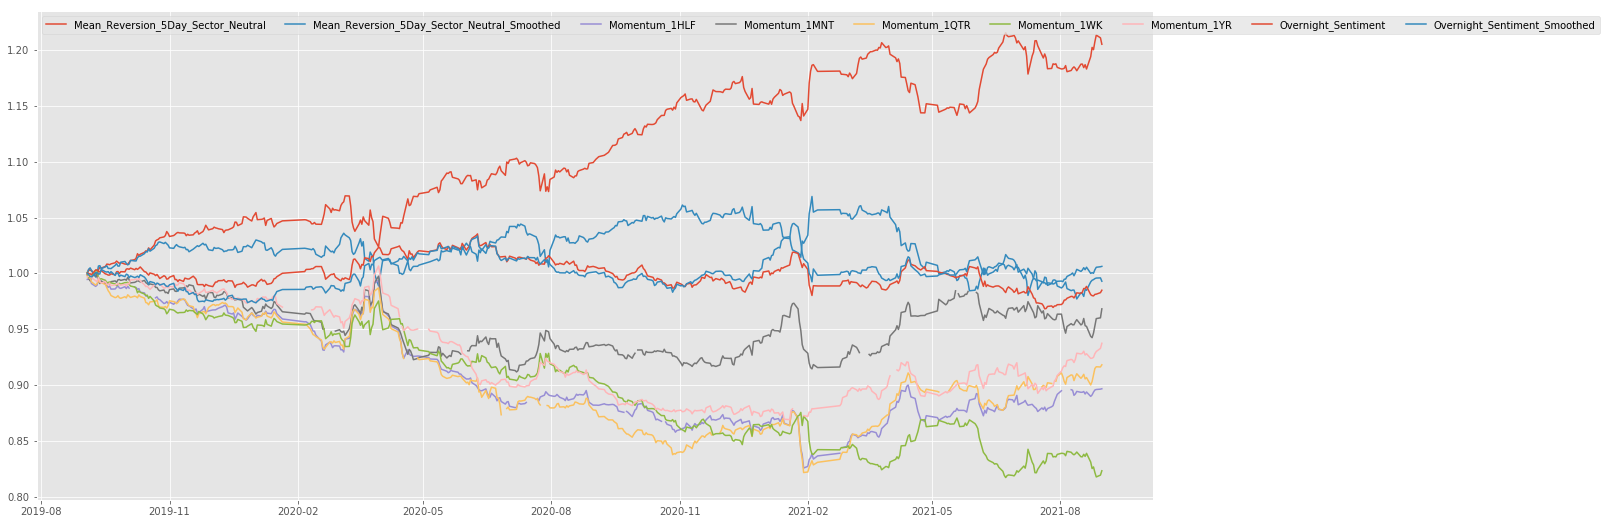

In [ ]:
 colors = ['red','green','yellow','blue','cyan','black','purple','orange','brown','magenta']
plt.figure(figsize=(30, 15))
for i, col in enumerate(ls_factor_returns.columns):
  plt.plot((1+ls_factor_returns[col]).cumprod(),color=colors[i])
plt.legend(ls_factor_returns.columns,loc="upper left",ncol=len(ls_factor_returns.columns),title_fontsize=20)
plt.show()

In [ ]:
clean_factor_data['Mean_Reversion_5Day_Sector_Neutral'].loc[pd.IndexSlice['2019-09-03 00:00:00+00:00',:]].mean()

1D                -0.00591965
factor            -0.00000000
factor_quantile    3.00000000
dtype: float64

In [ ]:
ls_factor_returns

Mean_Reversion_5Day_Sector_Neutral  \
date                                                            
2019-09-03 00:00:00+00:00                         -0.00074520   
2019-09-04 00:00:00+00:00                          0.00428743   
2019-09-05 00:00:00+00:00                         -0.00087320   
2019-09-06 00:00:00+00:00                         -0.00005471   
2019-09-09 00:00:00+00:00                         -0.00549763   
2019-09-10 00:00:00+00:00                          0.00035072   
2019-09-11 00:00:00+00:00                          0.00598458   
2019-09-12 00:00:00+00:00                          0.00172426   
2019-09-13 00:00:00+00:00                         -0.00037959   
2019-09-16 00:00:00+00:00                          0.00143998   
2019-09-17 00:00:00+00:00                          0.00203152   
2019-09-18 00:00:00+00:00                         -0.00012735   
2019-09-19 00:00:00+00:00                         -0.00041642   
2019-09-20 00:00:00+00:00                          0.00076696   
2019-09-23 00:00:00+00:00                          0.00099988   
2019-09-24 00:00:00+00:00                          0.00149093   
2019-09-25 00:00:00+00:00                         -0.00101702   
2019-09-26 00:00:00+00:00                         -0.00102363   
2019-09-27 00:00:00+00:00                          0.00068927   
2019-09-30 00:00:00+00:00                         -0.00131489   
2019-10-01 00:00:00+00:00                         -0.00006556   
2019-10-02 00:00:00+00:00                         -0.00024339   
2019-10-03 00:00:00+00:00                          0.00183245   
2019-10-04 00:00:00+00:00                          0.00156416   
2019-10-07 00:00:00+00:00                          0.00085201   
2019-10-08 00:00:00+00:00                          0.00120464   
2019-10-09 00:00:00+00:00                          0.00403076   
2019-10-10 00:00:00+00:00                         -0.00159746   
2019-10-11 00:00:00+00:00                          0.00112325   
2019-10-14 00:00:00+00:00                          0.00164598   
...                                                       ...   
2021-07-21 00:00:00+00:00                          0.00303667   
2021-07-22 00:00:00+00:00                         -0.00292209   
2021-07-23 00:00:00+00:00                         -0.00817121   
2021-07-26 00:00:00+00:00                          0.00022010   
2021-07-27 00:00:00+00:00                          0.00348244   
2021-07-28 00:00:00+00:00                         -0.00039897   
2021-07-29 00:00:00+00:00                          0.00041777   
2021-07-30 00:00:00+00:00                         -0.00270001   
2021-08-02 00:00:00+00:00                         -0.00119574   
2021-08-03 00:00:00+00:00                          0.00009872   
2021-08-04 00:00:00+00:00                          0.00042051   
2021-08-05 00:00:00+00:00                          0.00205481   
2021-08-06 00:00:00+00:00                         -0.00463930   
2021-08-09 00:00:00+00:00                          0.00095222   
2021-08-10 00:00:00+00:00                          0.00169210   
2021-08-11 00:00:00+00:00                          0.00103704   
2021-08-12 00:00:00+00:00                         -0.00112938   
2021-08-13 00:00:00+00:00                         -0.00181313   
2021-08-16 00:00:00+00:00                          0.00501845   
2021-08-17 00:00:00+00:00                          0.00003665   
2021-08-18 00:00:00+00:00                         -0.00267607   
2021-08-19 00:00:00+00:00                          0.00222500   
2021-08-20 00:00:00+00:00                         -0.00325822   
2021-08-23 00:00:00+00:00                          0.00931513   
2021-08-24 00:00:00+00:00                          0.00697965   
2021-08-25 00:00:00+00:00                         -0.00170360   
2021-08-26 00:00:00+00:00                          0.00597218   
2021-08-27 00:00:00+00:00                          0.00487353   
2021-08-30 00:00:00+00:00                         -0.00199059 

In [ ]:
unixt_factor_data['Momentum_1WK']

1D      factor  factor_quantile
date       asset                                                     
2019-09-03 Equity(0 [AAA])   -0.00310318 -0.43230226                2
           Equity(1 [AAV])   -0.01812367  1.42773510                5
           Equity(2 [ABC])   -0.03090508 -1.13194934                1
           Equity(3 [ABI])   -0.04521739  1.45048785                5
           Equity(5 [ABT])   -0.01283173  0.36973220                4
           Equity(6 [ACB])   -0.00514328 -0.65982977                2
           Equity(7 [ACC])   -0.01504355  0.48349595                4
           Equity(8 [ACE])    0.00000000 -1.21727216                1
           Equity(9 [ACL])    0.05024088  0.42092589                4
           Equity(10 [ACM])   0.25000000 -0.22752751                3
           Equity(11 [ACV])  -0.01482127  0.60294789                4
           Equity(13 [ADS])  -0.04804805 -0.91011003                2
           Equity(14 [AFX])   0.00000000 -1.42204692                1
           Equity(16 [AGM])  -0.00947368  1.43342329                5
           Equity(17 [AGR])   0.02922756 -0.22183932                3
           Equity(18 [AMD])   0.00000000 -0.43799045                2
           Equity(19 [AMS])   0.00000000  0.75652896                4
           Equity(20 [AMV])   0.00513259  1.30259497                5
           Equity(21 [ANV])   0.00000000 -0.21615113                3
           Equity(22 [APC])   0.01720430  0.62001245                4
           Equity(23 [APF])   0.00000000  1.65526261                5
           Equity(24 [APG])  -0.00131062 -0.61432427                2
           Equity(25 [APS])   0.00000000 -0.21046294                3
           Equity(26 [ART])  -0.05000000 -1.38222960                1
           Equity(27 [ASM])  -0.01645338 -0.28440938                3
           Equity(28 [ASP])  -0.04715673  1.16607847                5
           Equity(29 [AST])   0.02435117 -1.10919659                1
           Equity(30 [ATB])   0.00000000  1.61544530                5
           Equity(31 [ATG])  -0.01818182 -0.54606602                2
           Equity(32 [BAB])   0.00000000  0.68827071                4
...                                  ...         ...              ...
2021-08-31 Equity(590 [VNR])  0.01083032  1.13665988                5
           Equity(591 [VNS]) -0.01030928 -0.45295469                2
           Equity(592 [VNT])  0.09951846 -0.86887535                2
           Equity(593 [VOC])  0.00699301  1.22782057                5
           Equity(594 [VOS])  0.06756757  1.63804369                5
           Equity(595 [VPB]) -0.00162338 -0.76062202                2
           Equity(596 [VPD])  0.02364865 -0.73213431                2
           Equity(597 [VPG])  0.00550459  0.60109081                4
           Equity(598 [VPH])  0.04411765 -0.41307189                2
           Equity(599 [VPI]) -0.00476190 -0.84608517                2
           Equity(601 [VRC])  0.05548217 -0.72073922                2
           Equity(602 [VRE])  0.02197802  0.02563894                3
           Equity(603 [VRG])  0.04184100  0.44725715                4
           Equity(604 [VSC]) -0.00149254  0.76631957                4
           Equity(605 [VSH])  0.06884058 -0.15098490                3
           Equity(606 [VSI])  0.00000000  1.66083386                5
           Equity(607 [VSN])  0.01020408  0.20226279                3
           Equity(608 [VTB])  0.00884956 -0.82329500                2
           Equity(609 [VTD])  0.00000000  0.01424386                3
           Equity(610 [VTK])  0.00000000 -0.98282621                2
           Equity(611 [VTO])  0.02843602  1.47281493                5
           Equity(612 [VTP])  0.00245399 -0.30481856                3
           Equity(613 [VTR])  0.00000000 -1.24491320                1
           Equity(614 [VXP])  0.00000000 -0.97712867                2
           Equity(615 [WCS]) -0.01092896 -1.4101

#### Basis Points Per Day per Quantile
It is not enough to look just at the factor weighted return. A good alpha is also monotonic in quantiles. Let's looks the basis points for the factor returns.

In [ ]:
qr_factor_returns = pd.DataFrame()

#Computes mean returns for factor quantiles across provided forward returns columns
for factor, factor_data in unixt_factor_data.items():
    #get mean returns of each quantile through the time
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e86454a90>,
      dtype=object)

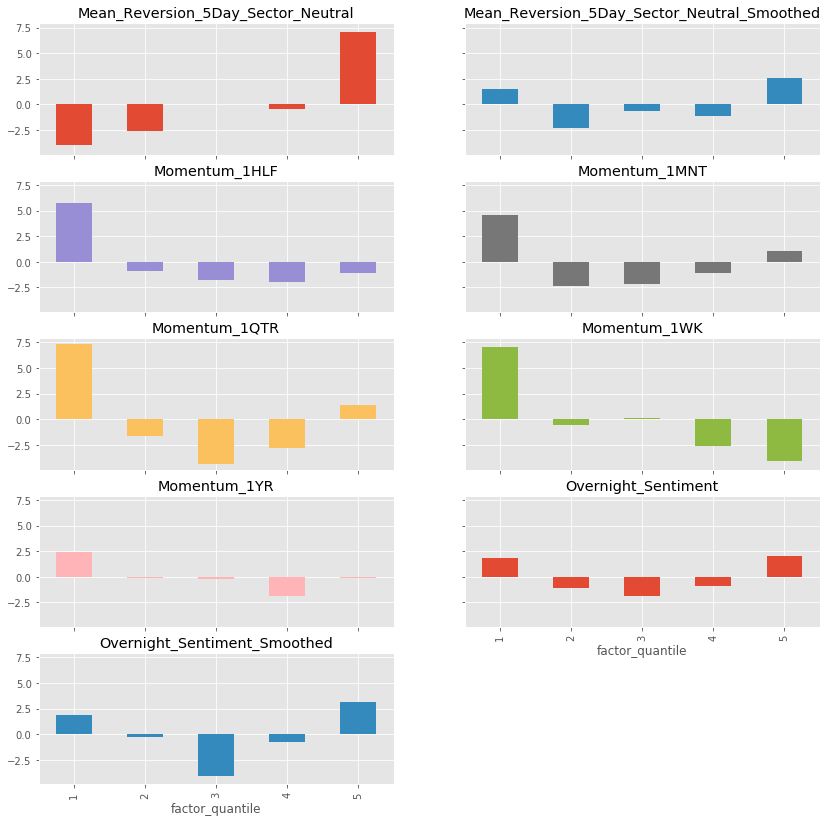

In [ ]:
(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(5,2),
    figsize=(20, 14),
    legend=False)

In [ ]:
best_quantile = {}

#Filter the best quantiles by factors that contain target stocks for trading
for factor, factor_data in clean_factor_data.items():
    #get time & ticker by best quantile    
    if factor == 'Mean_Reversion_5Day_Sector_Neutral':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 5].index.values.tolist()
    if factor == 'Mean_Reversion_5Day_Sector_Neutral_Smoothed':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 5].index.values.tolist()
    if factor == 'Momentum_1HLF':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 1].index.values.tolist()
    if factor == 'Momentum_1MNT':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 5].index.values.tolist()
    if factor == 'Momentum_1QTR':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 1].index.values.tolist()
    if factor == 'Momentum_1WK':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 1].index.values.tolist()
    if factor == 'Momentum_1YR':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 1].index.values.tolist()
    if factor == 'Overnight_Sentiment':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 5].index.values.tolist()
    if factor == 'Overnight_Sentiment_Smoothed':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 5].index.values.tolist()

In [ ]:
len(best_quantile['Mean_Reversion_5Day_Sector_Neutral']),len(best_quantile['Momentum_1MNT']),len(best_quantile['Momentum_1YR']),len(best_quantile['Overnight_Sentiment_Smoothed'])

(56923, 56847, 56004, 60201)

In [ ]:
ls_factor_returns_quantile = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    if factor == 'Mean_Reversion_5Day_Sector_Neutral':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 5]).iloc[:, 0]
    if factor == 'Mean_Reversion_5Day_Sector_Neutral_Smoothed':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 5]).iloc[:, 0]
    if factor == 'Momentum_1HLF':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 5]).iloc[:, 0]
    if factor == 'Momentum_1MNT':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 5]).iloc[:, 0]
    if factor == 'Momentum_1QTR':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 5]).iloc[:, 0]
    if factor == 'Momentum_1WK':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 5]).iloc[:, 0]
    if factor == 'Momentum_1YR':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 5]).iloc[:, 0]
    if factor == 'Overnight_Sentiment':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 5]).iloc[:, 0]
    if factor == 'Overnight_Sentiment_Smoothed':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 5]).iloc[:, 0]

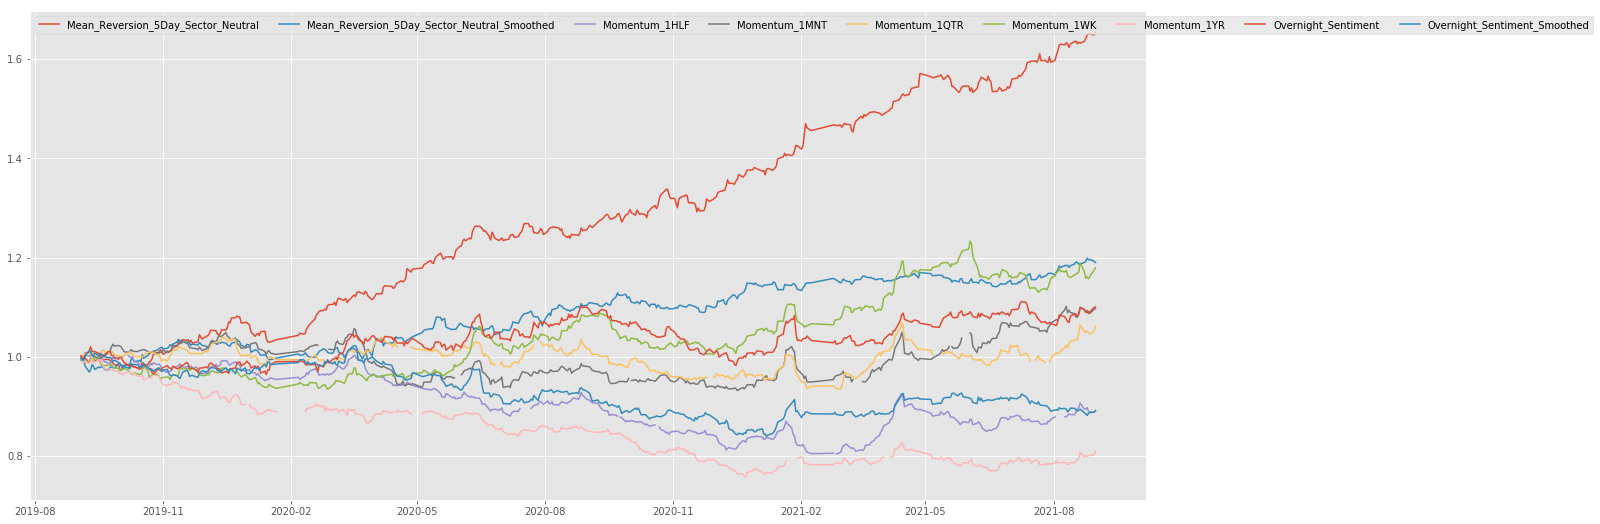

In [ ]:
colors = ['red','green','yellow','blue','cyan','black','purple','orange','brown','magenta']
plt.figure(figsize=(30, 15))
for i, col in enumerate(ls_factor_returns_quantile.columns):
  plt.plot((1+ls_factor_returns_quantile[col]).cumprod(),color=colors[i])
plt.legend(ls_factor_returns_quantile.columns,loc="upper left",ncol=len(ls_factor_returns_quantile.columns))
plt.show()

In [ ]:
qr_factor_returns

Mean_Reversion_5Day_Sector_Neutral  \
factor_quantile                                       
1                                       -0.00040157   
2                                       -0.00026271   
3                                        0.00000195   
4                                       -0.00004529   
5                                        0.00070658   

                 Mean_Reversion_5Day_Sector_Neutral_Smoothed  Momentum_1HLF  \
factor_quantile                                                               
1                                                 0.00015297     0.00056935   
2                                                -0.00023473    -0.00009000   
3                                                -0.00006497    -0.00017477   
4                                                -0.00011686    -0.00019621   
5                                                 0.00026187    -0.00011178   

                 Momentum_1MNT  Momentum_1QTR  Momentum_1WK  Momentum_1YR  \
factor_quantile                                                             
1                   0.00045452     0.00073217    0.00070903    0.00024328   
2                  -0.00023573    -0.00015927   -0.00006038   -0.00001059   
3                  -0.00021815    -0.00043225    0.00001072   -0.00002635   
4                  -0.00010714    -0.00028259   -0.00025963   -0.00019239   
5                   0.00010212     0.00013579   -0.00040302   -0.00001448   

                 Overnight_Sentiment  Overnight_Sentiment_Smoothed  
factor_quantile                                                     
1                         0.00017941                    0.00019196  
2                        -0.00010564                   -0.00002600  
3                        -0.00018665                   -0.00040959  
4                        -0.00008707                   -0.00007698  
5                         0.00019858                    0.00031858

What do you observe?

- None of these alphas are **strictly monotonic**; this should lead you to question why this is? Further research and refinement of the alphas needs to be done. What is it about these alphas that leads to the highest ranking stocks in all alphas except MR 5D smoothed to *not* perform the best.
- The majority of the return is coming from the **short side** in all these alphas. The negative return in quintile 1 is very large in all alphas. This could also a cause for concern because when you short stocks, you need to locate the short; shorts can be expensive or not available at all.
- If you look at the magnitude of the return spread (i.e., Q1 minus Q5), we are working with daily returns in the 0.03%, i.e., **3 basis points**, neighborhood *before all transaction costs, shorting costs, etc.*. Assuming 252 days in a year, that's 7.56% return annualized. Transaction costs may cut this in half. As such, it should be clear that these alphas can only survive in an institutional setting and that leverage will likely need to be applied in order to achieve an attractive return.

## Turnover Analysis

Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **factor rank autocorrelation (FRA)**. 
[alphalens.performance.factor_rank_autocorrelation](https://quantopian.github.io/alphalens/alphalens.html?highlight=factor_rank_autocorrelation#alphalens.performance.factor_rank_autocorrelation)

In [ ]:
ls_FRA = pd.DataFrame()

#Computes autocorrelation of mean factor ranks in specified time spans.
for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

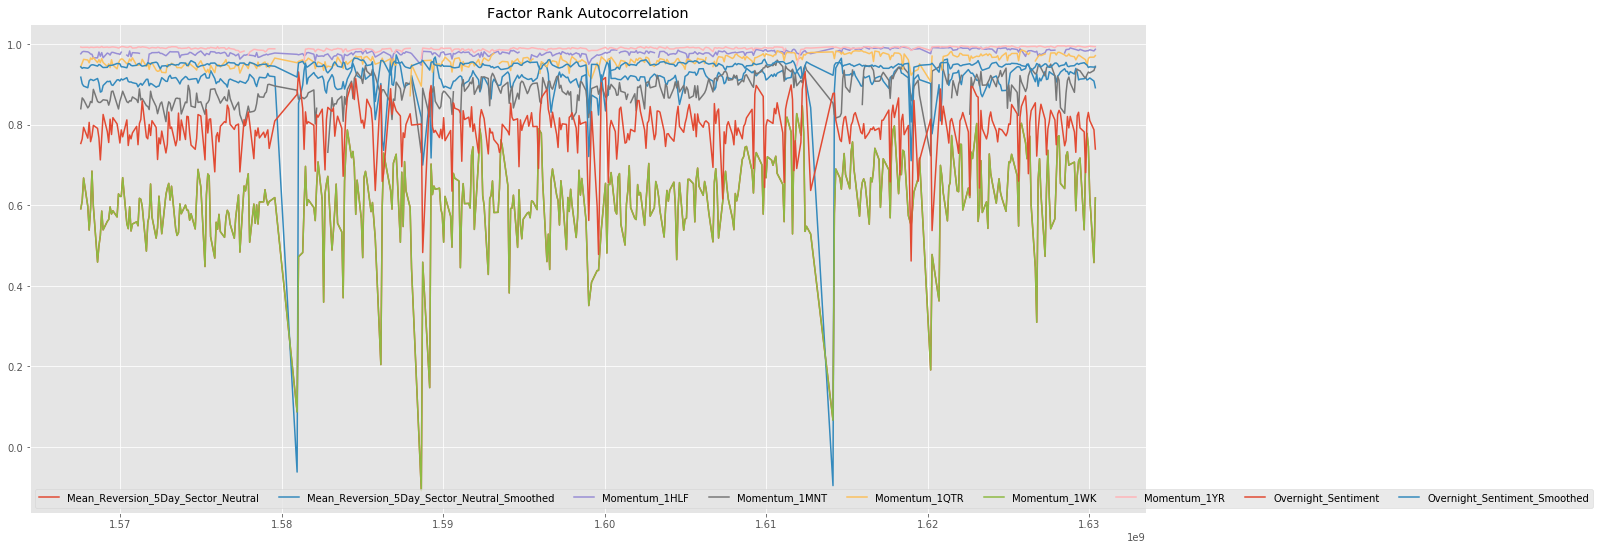

In [ ]:
plt.figure(figsize=(30, 35))
for i, col in enumerate(ls_FRA.columns):
  plt.plot(ls_FRA[col],color=colors[i])
plt.title("Factor Rank Autocorrelation")
plt.legend(ls_FRA.columns,loc="upper left",ncol=len(ls_FRA.columns))
plt.show()

In [ ]:
ls_FRA_clean = ls_FRA.copy()
ls_FRA_clean['dates'] = pd.to_datetime(ls_FRA.index,unit='s')
ls_FRA_clean.set_index(ls_FRA_clean['dates'],inplace=True)

In [ ]:
ls_FRA_clean.drop(['dates'],axis=1,inplace=True)
ls_FRA_clean.head(2)

Mean_Reversion_5Day_Sector_Neutral  \
dates                                            
2019-09-03                                 nan   
2019-09-04                          0.59156638   

            Mean_Reversion_5Day_Sector_Neutral_Smoothed  Momentum_1HLF  \
dates                                                                    
2019-09-03                                          nan            nan   
2019-09-04                                   0.91821730     0.97635344   

            Momentum_1MNT  Momentum_1QTR  Momentum_1WK  Momentum_1YR  \
dates                                                                  
2019-09-03            nan            nan           nan           nan   
2019-09-04     0.83989948     0.94486715    0.59156638    0.99316983   

            Overnight_Sentiment  Overnight_Sentiment_Smoothed  
dates                                                          
2019-09-03                  nan                           nan  
2019-09-04           0.75366401                    0.94392476

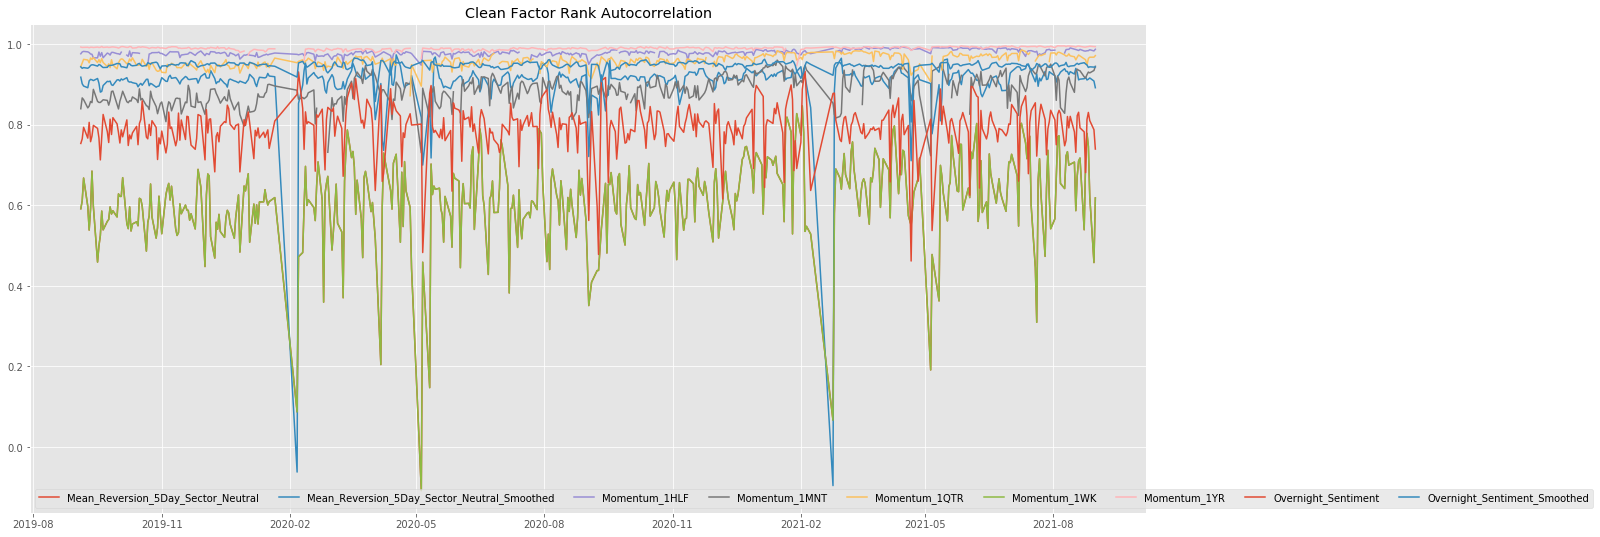

In [ ]:
plt.figure(figsize=(30, 30))
for i, col in enumerate(ls_FRA_clean.columns):
  plt.plot(ls_FRA[col],color=colors[i])
plt.title("Clean Factor Rank Autocorrelation")
plt.legend(ls_FRA_clean.columns,loc="upper left",ncol=len(ls_FRA_clean.columns))
plt.show()

#### Sharpe Ratio of the Alphas

The last analysis we'll do on the factors will be sharpe ratio. Implement `sharpe_ratio` to calculate the sharpe ratio of factor returns.

### View Data
Let's see what the sharpe ratio for the factors are. Generally, a Sharpe Ratio of near 1.0 or higher is an acceptable single alpha for this universe.

In [ ]:
daily_annualization_factor = np.sqrt(252)

amf.sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

Mean_Reversion_5Day_Sector_Neutral             1.58000000
Mean_Reversion_5Day_Sector_Neutral_Smoothed   -0.03000000
Momentum_1HLF                                 -0.98000000
Momentum_1MNT                                 -0.24000000
Momentum_1QTR                                 -0.73000000
Momentum_1WK                                  -1.58000000
Momentum_1YR                                  -0.65000000
Overnight_Sentiment                           -0.18000000
Overnight_Sentiment_Smoothed                   0.10000000
dtype: float64

In [ ]:
amf.sharpe_ratio(ls_factor_returns_quantile, daily_annualization_factor).round(2)

Mean_Reversion_5Day_Sector_Neutral             3.54000000
Mean_Reversion_5Day_Sector_Neutral_Smoothed    1.36000000
Momentum_1HLF                                  0.37000000
Momentum_1MNT                                  0.61000000
Momentum_1QTR                                 -0.29000000
Momentum_1WK                                  -3.52000000
Momentum_1YR                                  -0.59000000
Overnight_Sentiment                            0.62000000
Overnight_Sentiment_Smoothed                  -0.69000000
dtype: float64

In [ ]:
all_factors.columns[[0, 4]]

Index(['Mean_Reversion_5Day_Sector_Neutral', 'Overnight_Sentiment_Smoothed'], dtype='object')

## The Combined Alpha Vector

To use these alphas in a portfolio, we need to combine them somehow so we get a single score per stock. This is a area where machine learning can be very helpful. In this module, however, we will take the simplest approach of combination: simply averaging the scores from each alpha.

In [ ]:
selected_factors = all_factors.columns[[0,8]]
print('Selected Factors: {}'.format(', '.join(selected_factors)))

#reduce 9 cols by averaging them to 1, keep rows
all_factors['alpha_vector'] = all_factors[selected_factors].mean(axis=1) 
alphas = all_factors[['alpha_vector']]
#alpha vector (500 rows/stocks) for 1 day in 2021 only
alpha_vector = alphas.loc[all_factors.index.get_level_values(0)[-1]] 
alpha_vector.tail()

Selected Factors: Mean_Reversion_5Day_Sector_Neutral, Overnight_Sentiment_Smoothed


alpha_vector
asset                          
Equity(616 [WSB])    0.41257608
Equity(617 [X26])    0.54567805
Equity(618 [YBM])    0.90380394
Equity(619 [YEG])    0.72585985
Equity(620 [YTC])    0.16560208

### 3.3. Multi-factor model: Optimal Portfolio Constrained by Risk Model

We have an alpha model and a risk model. Let's find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model.  
We'll be building the optimizer for this portfolio  
Cumulative returns of each weight scheme?

We have an alpha model and a risk model. Let's find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model.  
We'll be building the optimizer for this portfolio  
Cumulative returns of each weight scheme?

### Three weight schemes:

<p>- alphas exposes under risk model  <br>
optimal_weights1 = cvx.Maximize(alpha_vector.values.T * weights)</p>


<p>- alphas exposes under risk model with regularization weights  <br>
optimal_weights2 = cvx.Maximize((alpha_vector.values.T*weights)-self.lambda_reg*cvx.pnorm(weights,2))</p>


<p>- alphas exposes under risk model with target weights  <br>
optimal_weights2 = cvx.Minimize(-(alpha_vector.values.T*weights)+cvx.pnorm(weights-target_weights,2))</p>

How to deal with these weights:  
    1.find the corresponding stocks related to PC  
    2.apply weight scheme to each stock  
    3.compute anual returns & compare to index??  

In [ ]:
import multi_factor_funcs as mff

## Objective and Constraints
Using this class as a base class, you'll implement the `OptimalHoldings` class. There's two functions that need to be implemented in this class, the `_get_obj` and `_get_constraints` functions.

The `_get_obj` function should return an CVXPY objective function that maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

The `_get_constraints` function should return a list of the following constraints:
- $ r \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minimum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on individual holdings.

With the `OptimalHoldings` class implemented, let's see the weights it generates.

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


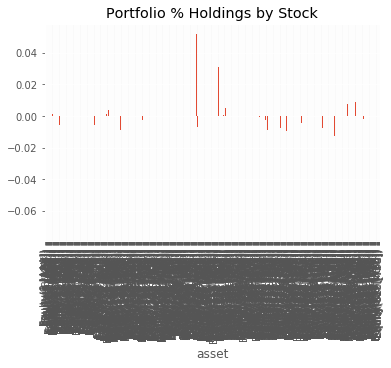

In [ ]:
#find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector) return optimum weights
optimal_weights = mff.OptimalHoldings().find(alpha_vector, risk_model['factor_betas'], 
                                         risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])
optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()

Yikes. It put most of the weight in a few stocks.

In [ ]:
factor_betas_weight = mff.get_factor_exposures(risk_model['factor_betas'], optimal_weights)
factor_betas_weight

0
0  -0.00358588
1   0.00086352
2  -0.00077699
3  -0.00040435
4  -0.00006326
5  -0.00168441
6   0.00122193
7   0.00058541
8   0.00267347
9   0.00039721
10  0.00149057
11 -0.00106908
12  0.00234249
13  0.00214664
14  0.00050222
15  0.00018699
16  0.00223662
17  0.00295250
18  0.00445333
19  0.00074099

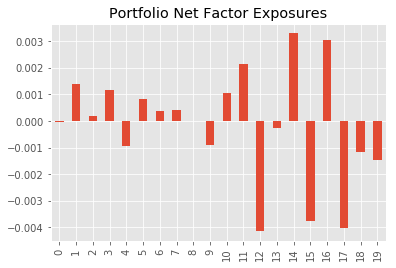

In [ ]:
factor_betas_weight.plot.bar(title='Portfolio Net Factor Exposures',legend=False)

## Optimize with a Regularization Parameter
In order to enforce diversification, we'll use regularization in the objective function. We'll create a new class called `OptimalHoldingsRegualization` which gets its constraints from the `OptimalHoldings` class. In this new class, implement the `_get_obj` function to return a CVXPY objective function that maximize $ \alpha^T * x + \lambda\|x\|_2\\ $, where $ x $ is the portfolio weights, $ \alpha $ is the alpha vector, and $ \lambda $ is the regularization parameter.

**Note:** * $ \lambda $ is located in `self.lambda_reg`. *

### View Data

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


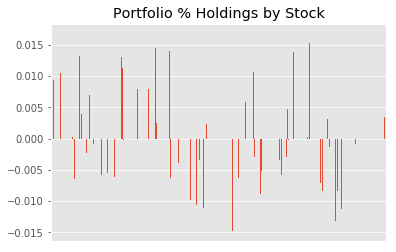

In [ ]:
#.find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector) return optimum weights
optimal_weights_1 = mff.OptimalHoldingsRegualization(lambda_reg=5.0).find(alpha_vector, 
                  risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

Nice. Well diversified.

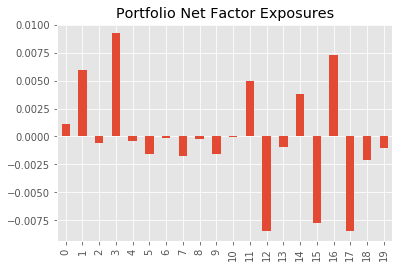

In [ ]:
mff.get_factor_exposures(risk_model['factor_betas'], optimal_weights_1).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Optimize with a Strict Factor Constraints and Target Weighting
Another common formulation is to take a predefined target weighting, $x^*$ (e.g., a quantile portfolio), and solve to get as close to that portfolio while respecting portfolio-level constraints. For this next class, `OptimalHoldingsStrictFactor`, you'll implement the `_get_obj` function to minimize on on $ \|x - x^*\|_2 $, where $ x $ is the portfolio weights  $ x^* $ is the target weighting.

### View Data

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


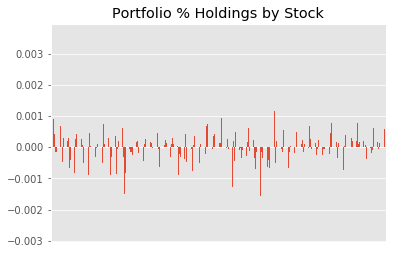

In [ ]:
#__init__(self,lambda_reg=0.5,risk_cap=0.05,factor_max=10.0,factor_min=-10.0,weights_max=0.55,weights_min=-0.55)
#.find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector) return optimum weights
optimal_weights_2 = mff.OptimalHoldingsStrictFactor(
    weights_max=0.02,
    weights_min=-0.02,
    risk_cap=0.0015,
    factor_max=0.015,
    factor_min=-0.015).find(alpha_vector,risk_model['factor_betas'],risk_model['factor_cov_matrix'], 
                            risk_model['idiosyncratic_var_vector'])

optimal_weights_2.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

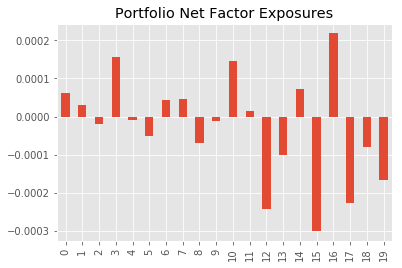

In [ ]:
mff.get_factor_exposures(risk_model['factor_betas'], optimal_weights_2).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

<h2>4. Conclusions & Recommendations</h2>